#  Библиотеки

In [1]:
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# OrdinalEncoder для присвоения порядковых номеров множеству данных
from sklearn.preprocessing import OrdinalEncoder
# инструменты для оценки точности модели
from sklearn.metrics import mean_absolute_error
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import missingno as msno
from scipy import stats
import scipy
import seaborn as sns
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline


# Убираем вывод предупреждений
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Базовые переменные

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# Постоянный сегодняшний день
date_today = pd.to_datetime('2020-11-24')
# Создадим дата фрейм для обработанных данных
df_tmp = pd.DataFrame()

# pd.options.display.float_format = '{:.4f}'.format
# pd.options.mode.chained_assignment = None

# Предобработка 

In [3]:


def pie_chart(df):
    """Показывает график Pie chart"""
    global_number_rest = df.value_counts(dropna=False)
    total_rest = global_number_rest.sum()
    explode = [0.1 for i in global_number_rest]
    global_number_rest.plot(kind='pie', figsize=(25, 25), explode=explode, fontsize=20, autopct=lambda v: int(v*total_rest/100))
    plt.figtext(.5,.9,df.name, fontsize=75, ha='center')


def get_boxplot(column):
    """Показывает boxplot"""
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='default',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def value_counts(name):
    """Показывает уникальные значения"""
    display(pd.DataFrame(name.value_counts(dropna=False)))
    
def value_counts_p(name):
    """Возвращает уникальные значения в процентах"""
    display(pd.DataFrame(round(name.value_counts(
        dropna=False, normalize=True)*100, 1)))

In [4]:
def bar(df, column, title, max_values=0):
    """ 
    возвращает горизонтальную визуализация 
    """
    if max_values > 0:
        col_values = df[column].value_counts().nlargest(
            max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (8, 10)
    plt.figure 
    ax = col_values.plot(kind='barh', title=title)
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()
    
    
def factorplot(x,y,title,xlabel):
    ''' Возвращает график распределения с целевой переменной'''
    sns.set(style="darkgrid")
    sns.catplot(x=x, y='default',  data=df, kind="bar", palette="Paired", size = 6, ci=None)
    plt.ylabel(u'Доля кредитов с просрочками')
    plt.xlabel(xlabel)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.title('Кредиты с просрочками, взависимости от {}'.format(title))

    
def iqr_test(column, lim_a, lim_b, bins, hist=True):
    """
    Функция определения медианы, квантилей 25%/75% и 
    границы выбросов для данного сталбцы 
    lim_a lim_b - пределы для построенния гистограммы
    """
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), 
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}]."
          .format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    if hist:
        df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].\
        hist(bins=bins, range=(lim_a, lim_b), label='IQR')
        
# Модель + метрики
def test_metrics(X, y, C=1.0, slv='lbfgs'):
    # Разобьем данные
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_SEED)

    # Сбалансируем Train по целевой переменной
#     # sm = SVMSMOTE(random_state=RANDOM_SEED, m_neighbors=50)
#     # X_train, y_train = sm.fit_resample(X_train, y_train)

#     # Балансировка массивами
#     # Объединим
#     sum_arr = np.hstack((X_train, y_train[:, np.newaxis]))
#     # Посчитаем дисбаланс
#     ones = sum_arr[sum_arr[:,3] == 1]
#     zeros = sum_arr[sum_arr[:,3] == 0]
#     add_ones_count = (round(zeros.shape[0] / ones.shape[0], 0)) - 1
#     # Создадим дополнительные строки
#     add_ones = np.repeat(ones, add_ones_count, axis=0)
#     # Добавим
#     sum_arr = np.vstack((sum_arr, add_ones))
#     # Перемешаем
#     np.random.shuffle(sum_arr)
#     # Обновим
#     X_train = sum_arr[:, :-1]
#     y_train = sum_arr[:, -1]

    # Обучим модель
    clf = LogisticRegression(random_state=RANDOM_SEED,
                             max_iter=500, C=C, solver=slv)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # ROC AUC
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.subplots(figsize=(8, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
       
        


# Загрузка данных

In [5]:
def load_data():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print('Размерность тренировочного датасета: ', df_train.shape)
    print('Размерность тестового датасета: ', df_test.shape)
    return df_train, df_test

## Описание данных


* client_id 	идентификатор клиента
* education 	уровень образования
* sex 	пол заёмщика
* age 	возраст заёмщика
* car 	флаг наличия автомобиля
* car_type 	флаг автомобиля-иномарки
* decline_app_cnt 	количество отказанных прошлых заявок
* good_work 	флаг наличия «хорошей» работы
* bki_request_cnt 	количество запросов в БКИ
* home_address 	категоризатор домашнего адреса
* work_address 	категоризатор рабочего адреса
* income 	доход заёмщика
* foreign_passport 	наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# Объеденяем датафрейм и помечаем 

In [6]:
df_train, df_test = load_data()
def combine_data():
    df_train['sample'] = 1  # помечаем где у нас трейн
    df_test['sample'] = 0  # помечаем где у нас тест 

    df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем
    df_tmp['sample'] = df['sample']
    return df, df_tmp

Размерность тренировочного датасета:  (73799, 19)
Размерность тестового датасета:  (36349, 18)


In [7]:
df, df_tmp = combine_data()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

**Вывод:**
* В тренировочной выборке 73799 клиентов, в тестовой выборке - 36349
* Всего данные о 110148 клиентах
* 19 переменных, из них 1 - временной ряд, 6 бинарных, 6 категориальных и 7 числовых

# Пропуски и дубликаты

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
sample                  0
default             36349
dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


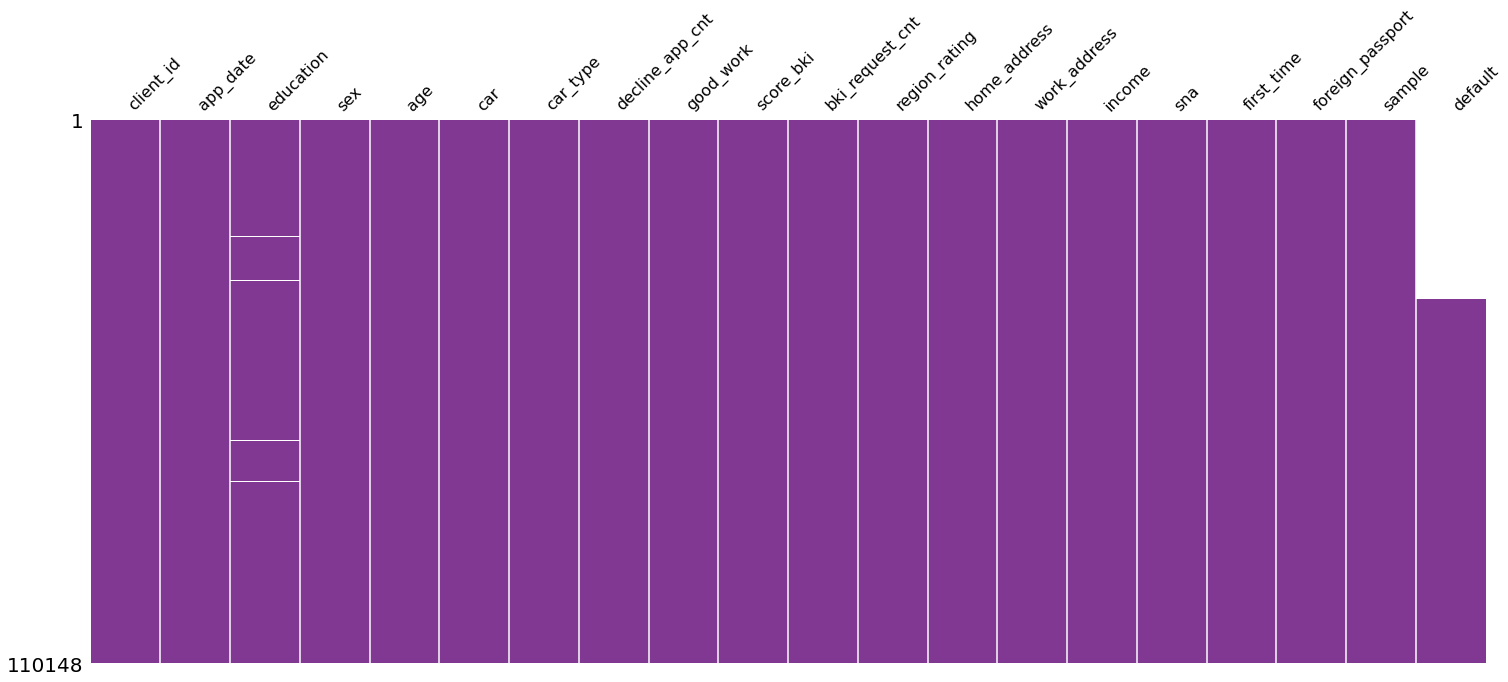

In [9]:
print(df.isna().sum(),msno.matrix(df, color=(0.505, 0.221, 0.578), sparkline=False))

In [10]:
df.duplicated().sum()

0

**Вывод:**
* Всего пропусков 478, все пропуски в переменной education.
* В признаки "default" тоже присутствуют пропуски, но эти пропуски мы должны предсказать
* Дубликаты отсутствуют

# Обработка признаков

## default - наличие дефолта(Целевая переменная)
*Дефо́лт (невыполнение обязательств) — невыполнение договора займа, то есть неоплата своевременно процентов или основного долга по долговым обязательствам или по условиям договора о выпуске облигационного займа.*

,default
0.0,58.5
NaN,33.0
1.0,8.5


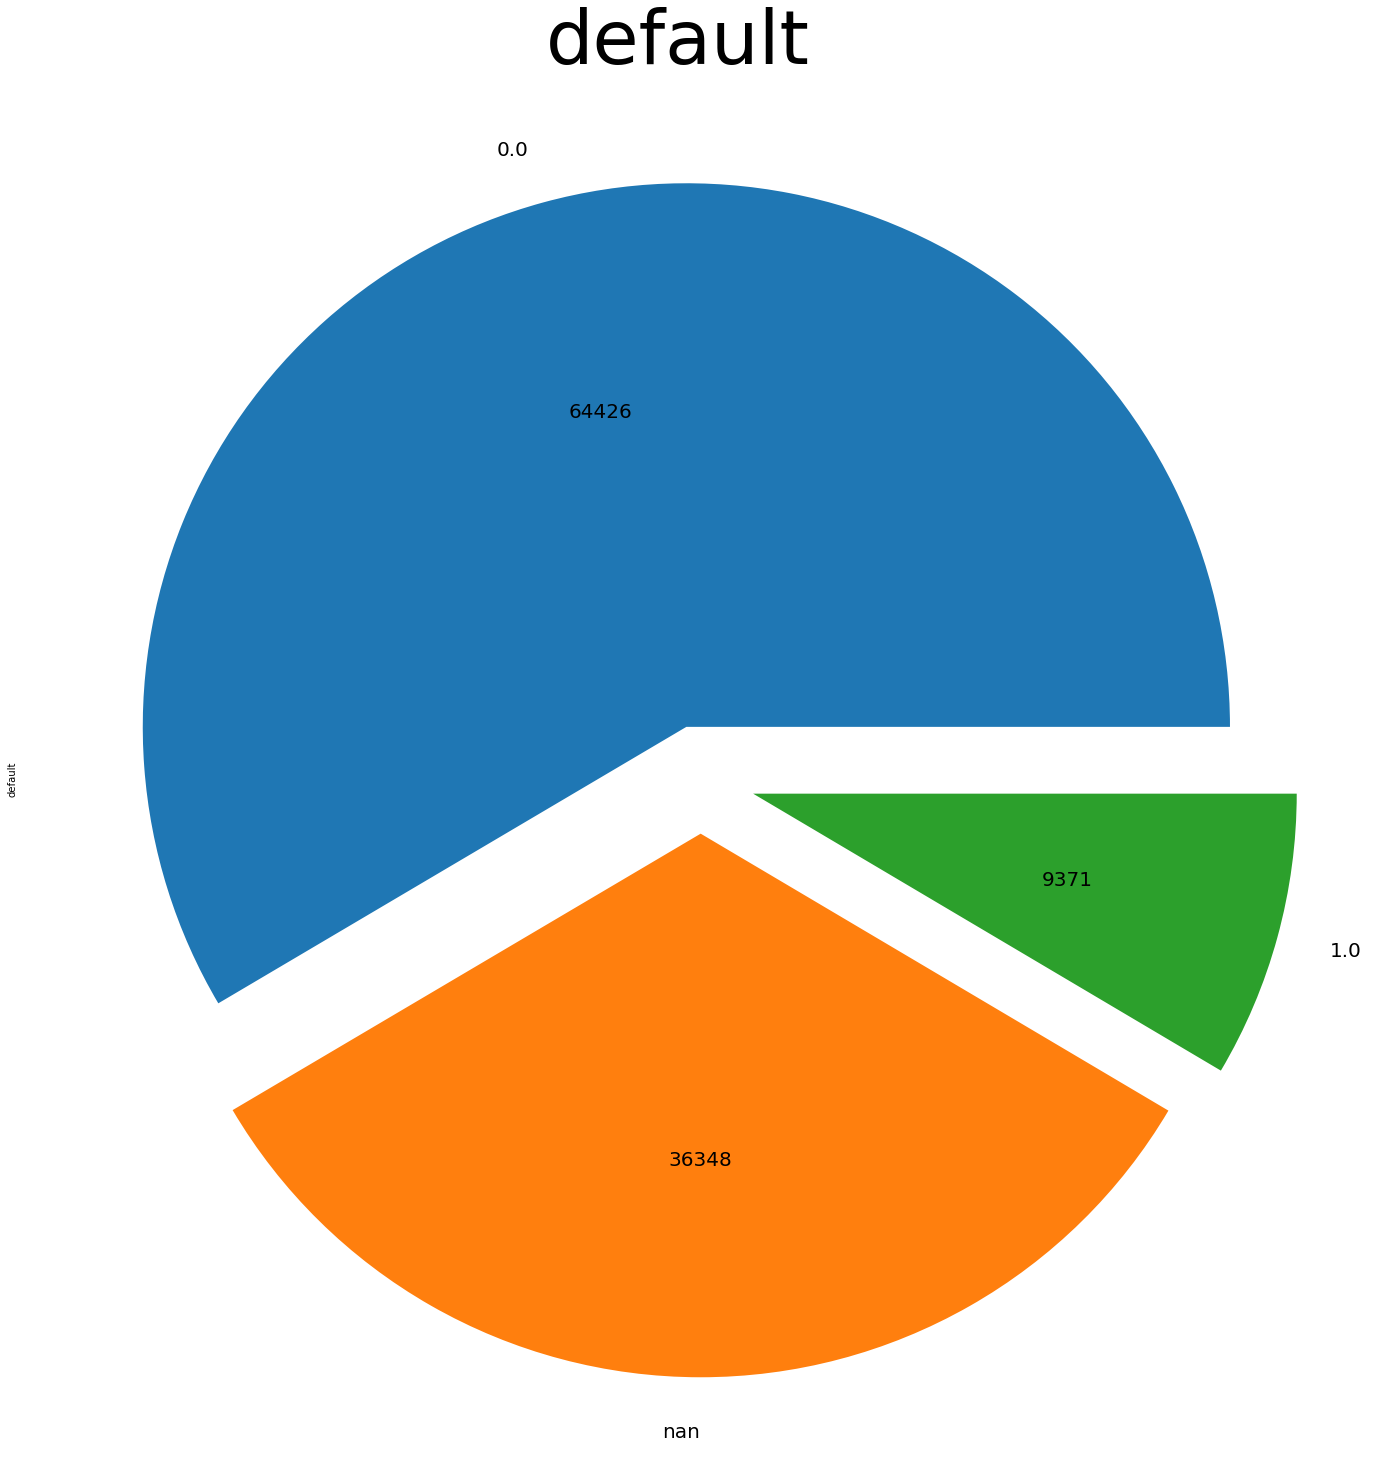

In [11]:
value_counts_p(df.default)
pie_chart(df['default'])

**Вывод:**
* Данные не сбалансированы
* Большинства заемщиков возвращали кредит вовремя
* Значение NaN - относится к тестовому дата сету. Его отделили специально, чтобы не учитывать при анализе параметров

## education - уровень образования

* SCH - школа
* UGR - кандидат в бакалавры
* GRD - бакалавр
* PRG - магистр
* ACD - академик

,education
SCH,52.7
GRD,31.6
UGR,13.4
PGR,1.7
NaN,0.4
ACD,0.3


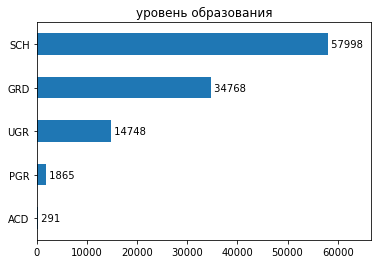

In [12]:
value_counts_p(df['education'])
bar(df, 'education', 'уровень образования')

**Вывод:**
* Мы можем увидить что большинство заемщиков, закончили только школу. Остальная половина с высшим образованием. И только 0,3% заемщики с академическим образование(и это логично,их и так моло)


* У нас имеются  пропущенные значений, заполним их самым часто встречающимся значением "SCH"



In [13]:
# Заполняем пропуски на основе уровня дохода

df['log_income'] = df.income.apply(lambda x: round(np.log(x)))
education_income = df.groupby('log_income')['education'].agg(pd.Series.mode).to_frame().reset_index()
education_income.rename(columns={'education': 'new_education'}, inplace=True)
df = df.merge(education_income, how='left', on='log_income')
df['education'] = df['education'].fillna(df['new_education'])
df.drop(columns=['log_income', 'new_education'], inplace=True)

#### Посмотрим как образование влияет на то, вернет ли человек долг.

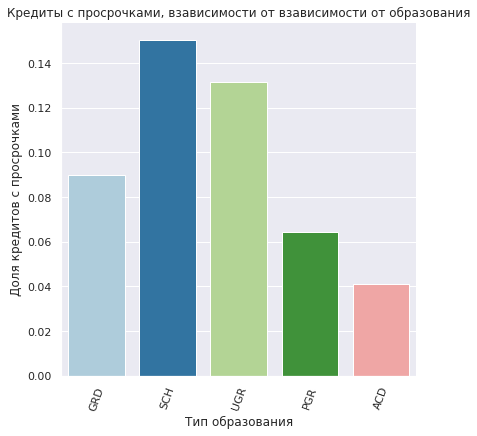

In [14]:
factorplot('education', 'default', 'взависимости от образования', 'Тип образования')

In [15]:
# Dummy-переменные в df_tmp
df_tmp['education'] = df['education']
df_tmp = pd.get_dummies(df_tmp, columns=['education'])


# Числовые перменные в df
df.education = df.education.apply(
    lambda x: 1 if x == 'ACD' else 2 if x == 'PGR' else 3 if x == 'UGR' else 4 if x == 'GRD' else 5)

**Вывод**:
* На графики видно, что значительно высокий  процент не возврата у заемщиков кто только закончил школу(SCCH),и кто кандидат в бакалавры(UGR). 

* Этот график явно показывает, чем выше уровень образования, тем заемщик более ответственнее 
* Зависимости образования и наличия/отсутствия просрочек в оплате кредита потверждается. Поэтому этот признак является важным при рассмотрении заявки на кредит.

Проведем первое тестирование с имеющимися данными

In [16]:
y = df_train['default'].values

<Figure size 576x720 with 0 Axes>

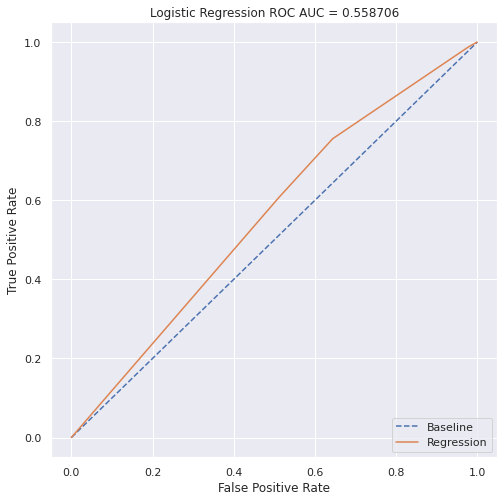

In [17]:
df_for_test = df_tmp.query('sample == 1').drop(['sample'], axis=1)
X = df_for_test.values
test_metrics(X, y)

## sex - пол заемщика
* M - мужчины
* F - женщины

,sex
F,56.1
M,43.9


(None, None)

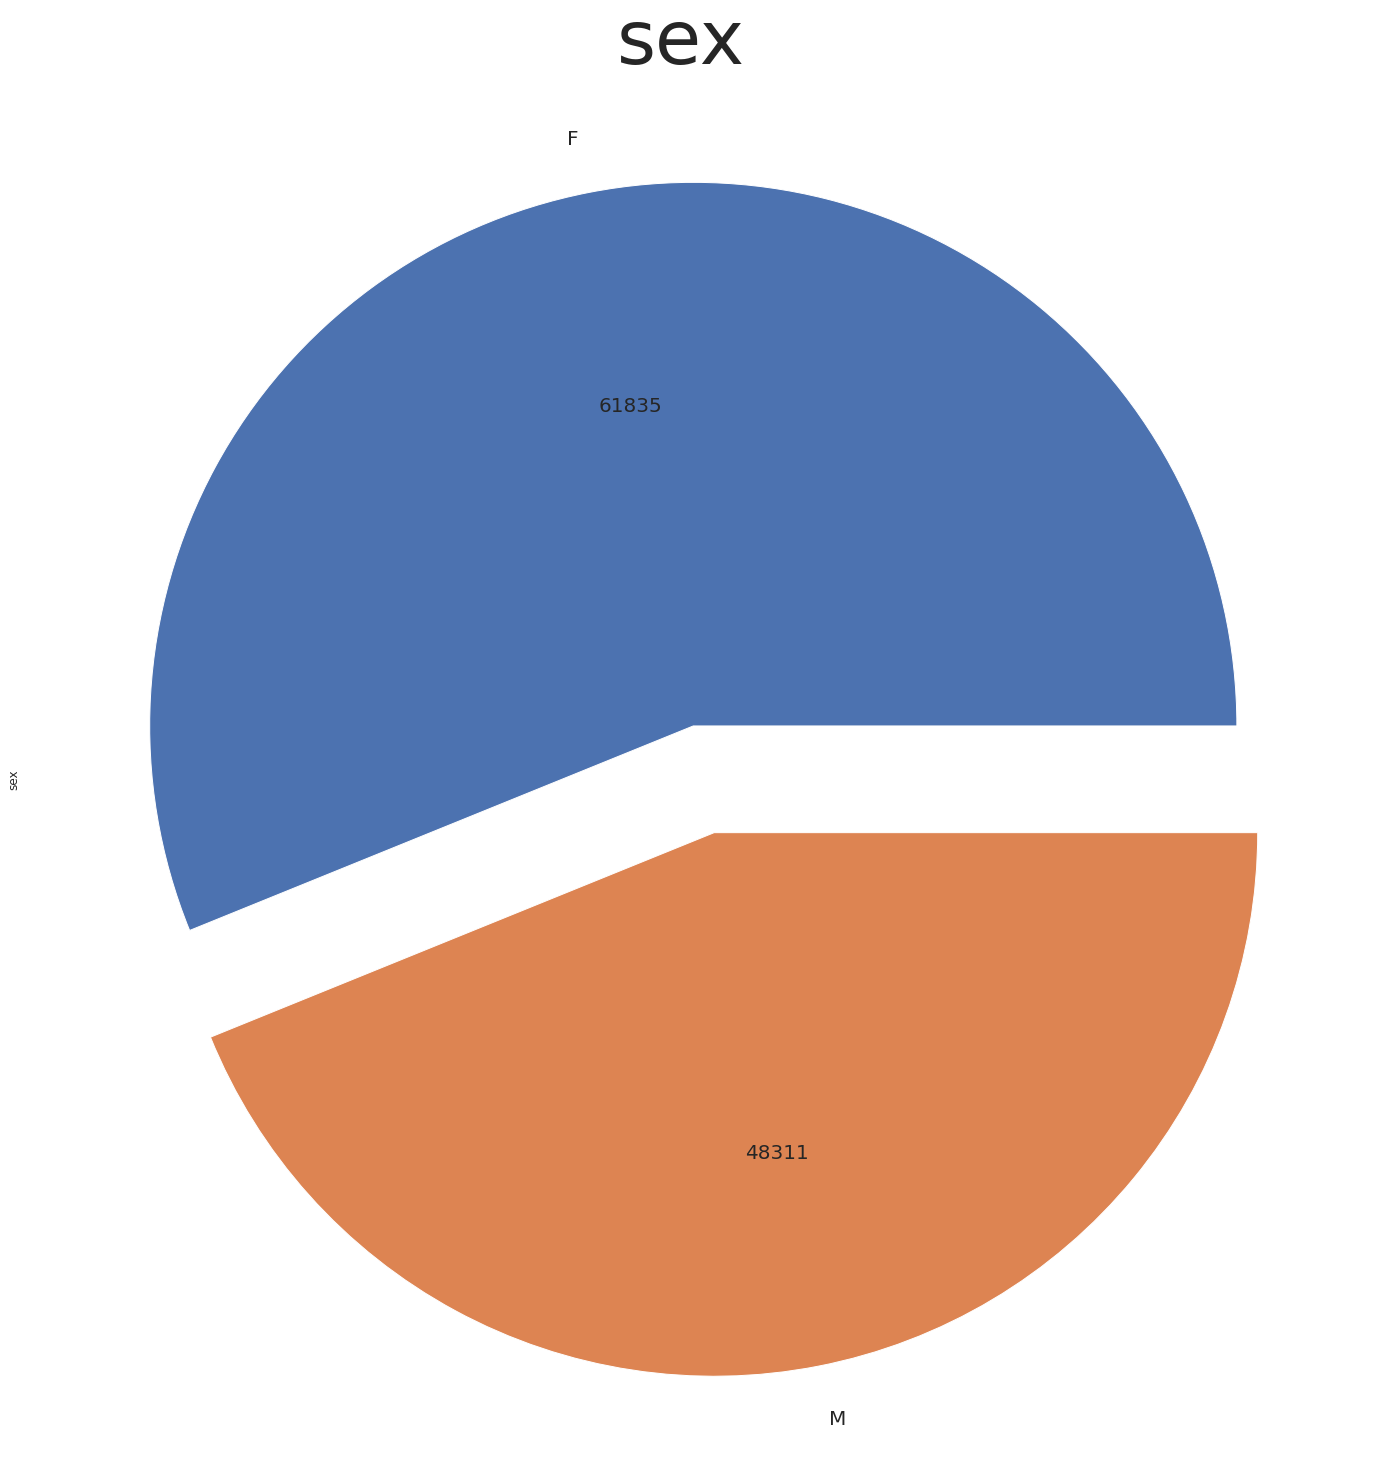

In [18]:
value_counts_p(df['sex']),pie_chart(df['sex'])


* Женщины берут чаще кридит, но всего на 12% больше 

#### Посмотрим как пол влияет на то, вернет ли человек долг.

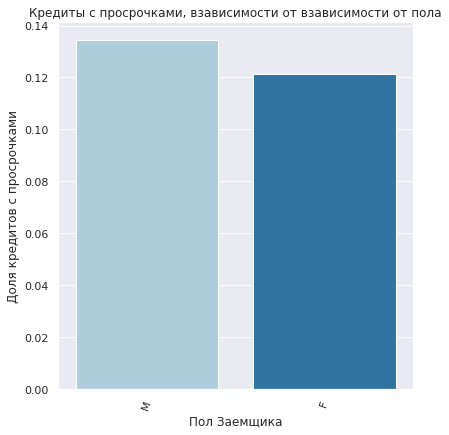

In [19]:
factorplot('sex', 'default', 'взависимости от пола', 'Пол Заемщика')

**Вывод**:
* На графики видно, что у мужнин процент по не возврата   выше чем женщин

* Женщины чаще берут кредит,и более ответственнее 
* Но разница не большая,Поэтому признак "sex" при построение модели можно считать не значимым.

In [20]:
# Преобразуем параметр в бинарный числовой формат
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df_tmp['sex'] = df['sex']

## age - возраст заемщика

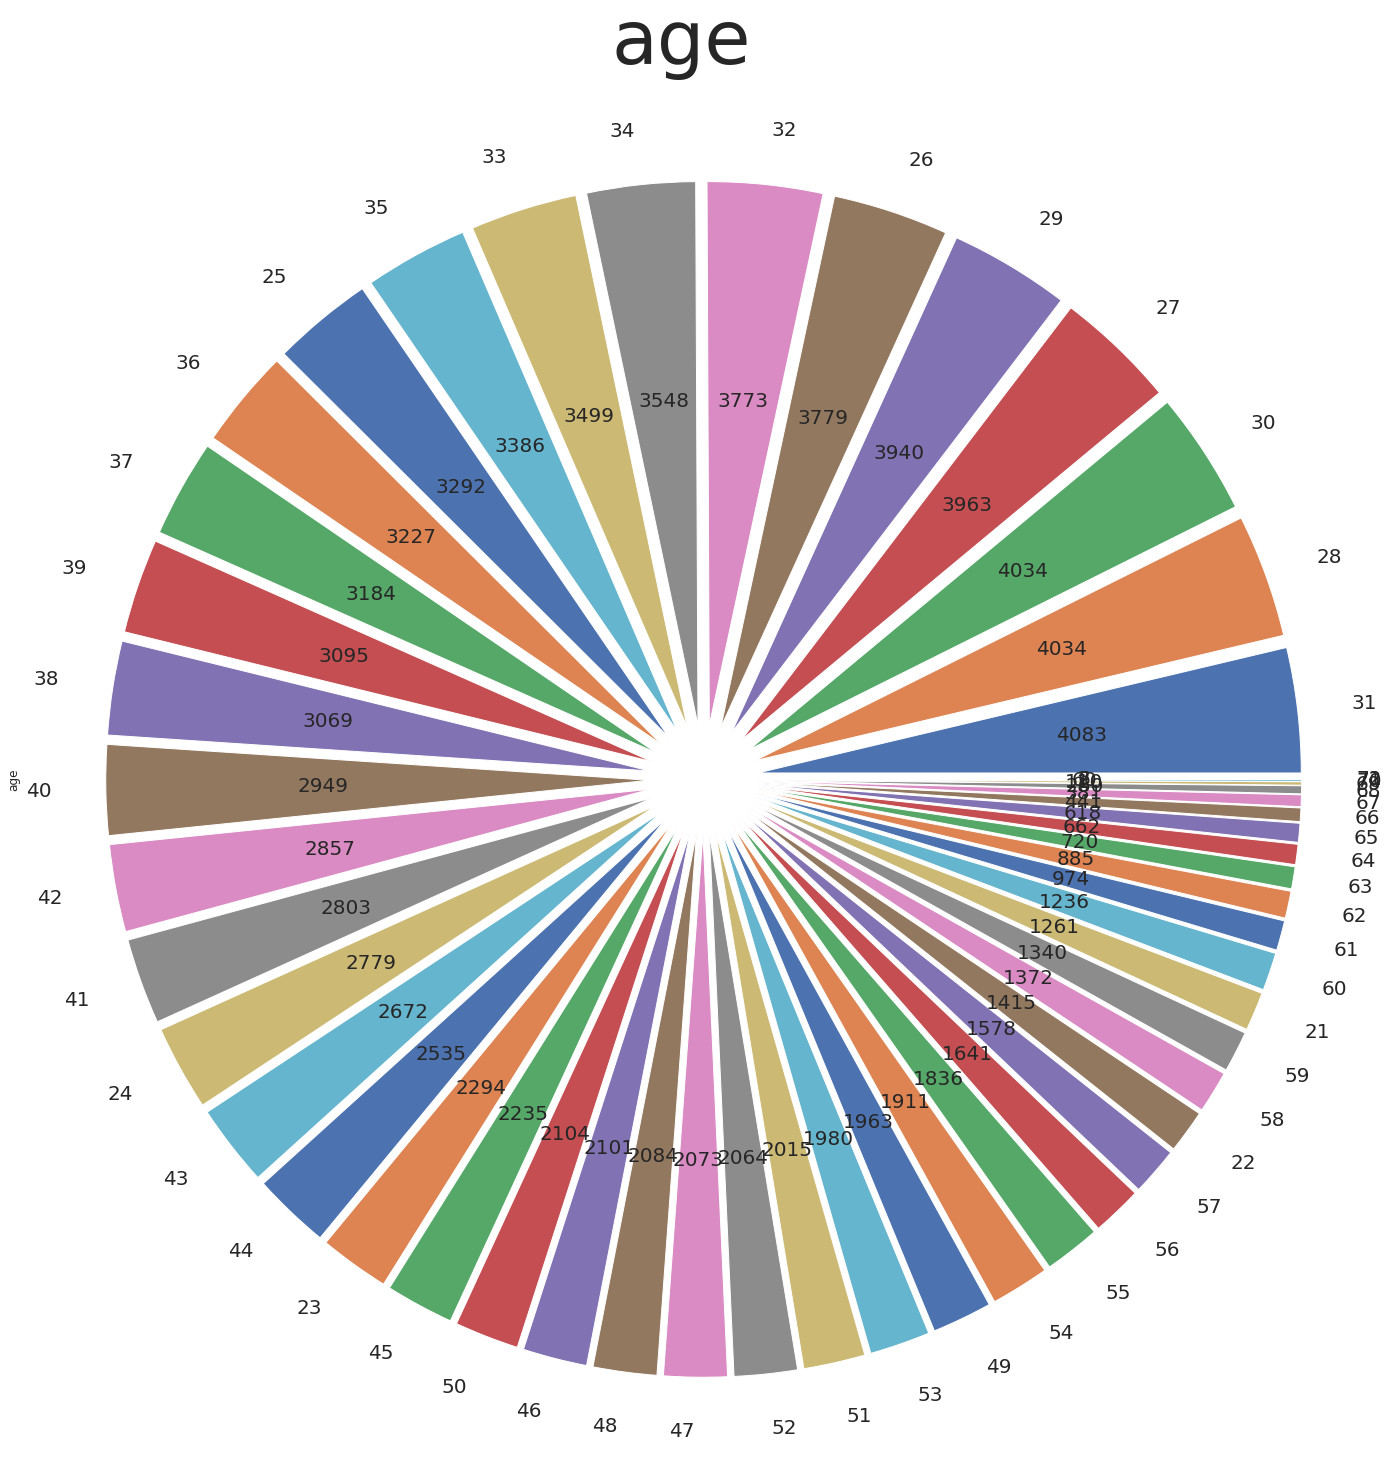

In [21]:
pie_chart(df['age'])

In [22]:
hist(df.age,50)

* Возраст от 21 до 72
*  Распредение логнормлаьное

### Посмотрим как возраст влияет на дефолт

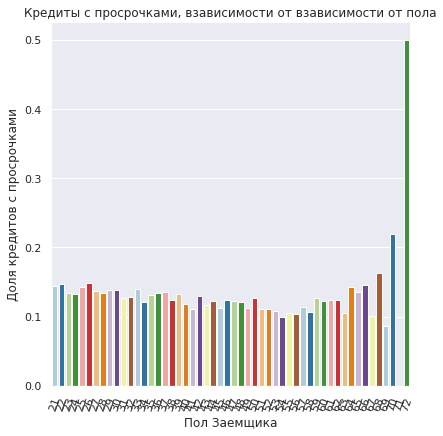

In [23]:
factorplot('age', 'default', 'взависимости от пола', 'Пол Заемщика')

<AxesSubplot:ylabel='Frequency'>

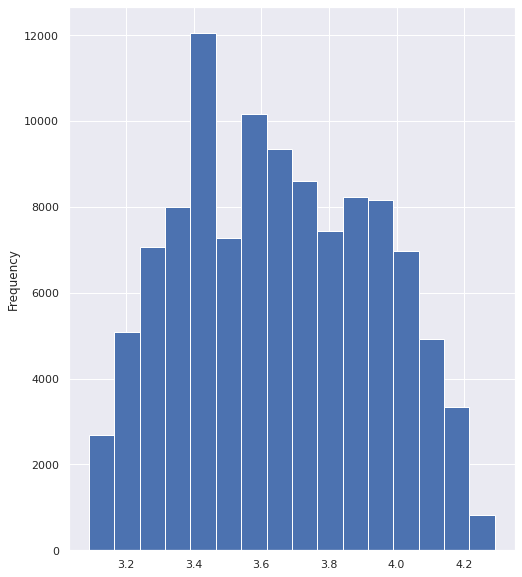

In [24]:
# Прологарифмируем данный столбец
df['age'] = np.log(df['age'] + 1)
df['age'].plot.hist(bins=16)

**Вывод**:
* Более молодые заемщики допускают дефолд по кридитам

In [25]:
# # Принадлежность к группам
# df_tmp['age_21_30'] = df.age.apply(lambda x: 1 if 20 < x < 31 else 0)
# df_tmp['age_31_40'] = df.age.apply(lambda x: 1 if 30 < x < 41 else 0)
# df_tmp['age_41_50'] = df.age.apply(lambda x: 1 if 40 < x < 51 else 0)
# df_tmp['age_51_60'] = df.age.apply(lambda x: 1 if 50 < x < 61 else 0)
# df_tmp['age_61_72'] = df.age.apply(lambda x: 1 if 60 < x < 73 else 0)

* Дало плохой результат

In [26]:
# # Принадлежность к группам
# df_tmp['age_25_32'] = df.age.apply(lambda x: 1 if 25 < x < 32 else 0)
# df_tmp['age_45_60'] = df.age.apply(lambda x: 1 if 45 < x < 60 else 0)

*  Стало еще хуже

## car -  наличия автомобиля

,car
N,67.4
Y,32.6


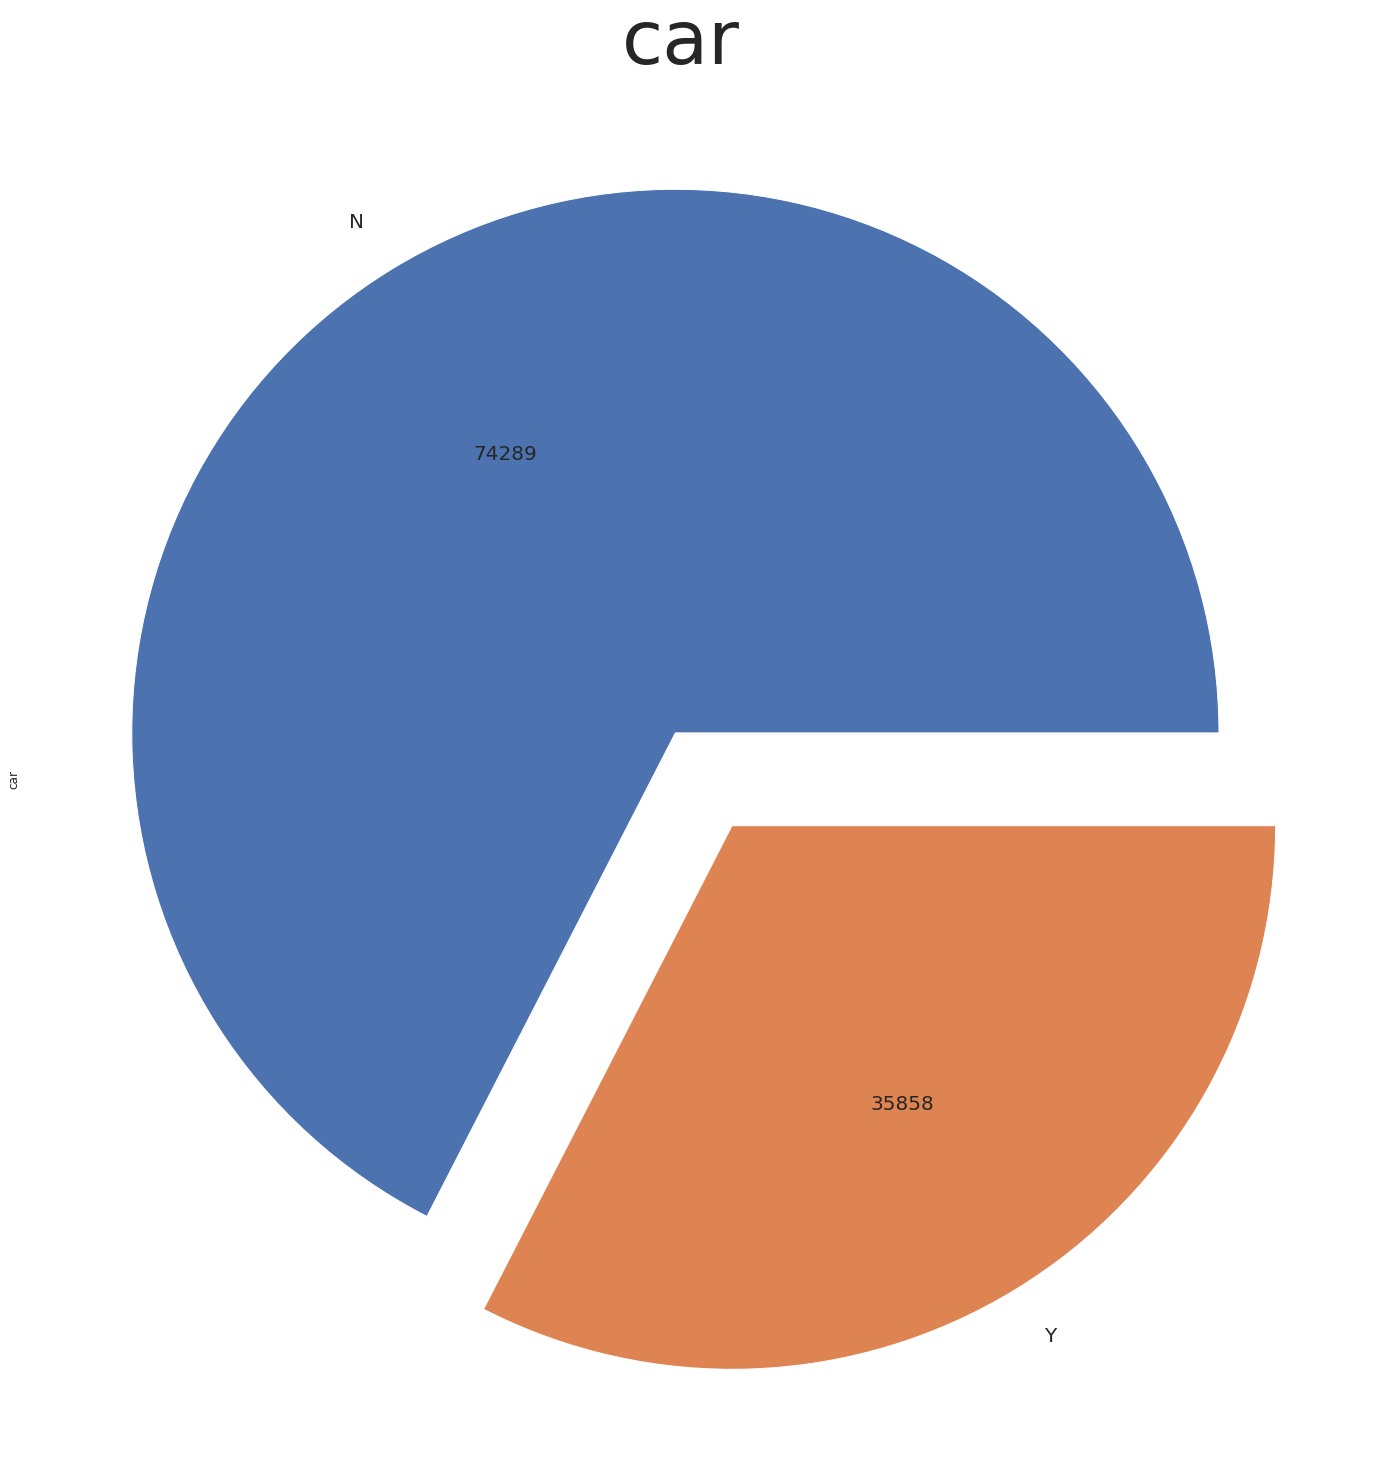

In [27]:
pie_chart(df['car'])
value_counts_p(df['car'])

* У 68% заемщиков нет автомобиля

#### Посмотрим как наличие автомобиля влияет на отдачу кредита

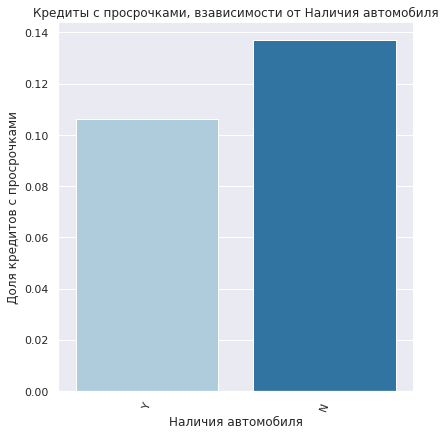

In [28]:
factorplot('car', 'default', 'Наличия автомобиля', 'Наличия автомобиля')

**Вывод**:
* У заемщиков у которых есть машина берут реже кредит 

In [29]:
# Преобразуем параметр в бинарный числовой формат
df['car'] = label_encoder.fit_transform(df['car'])
df_tmp['car'] = df['car']

## Car_type - флаг автомобиля-иномарки

,car_type
N,80.9
Y,19.1


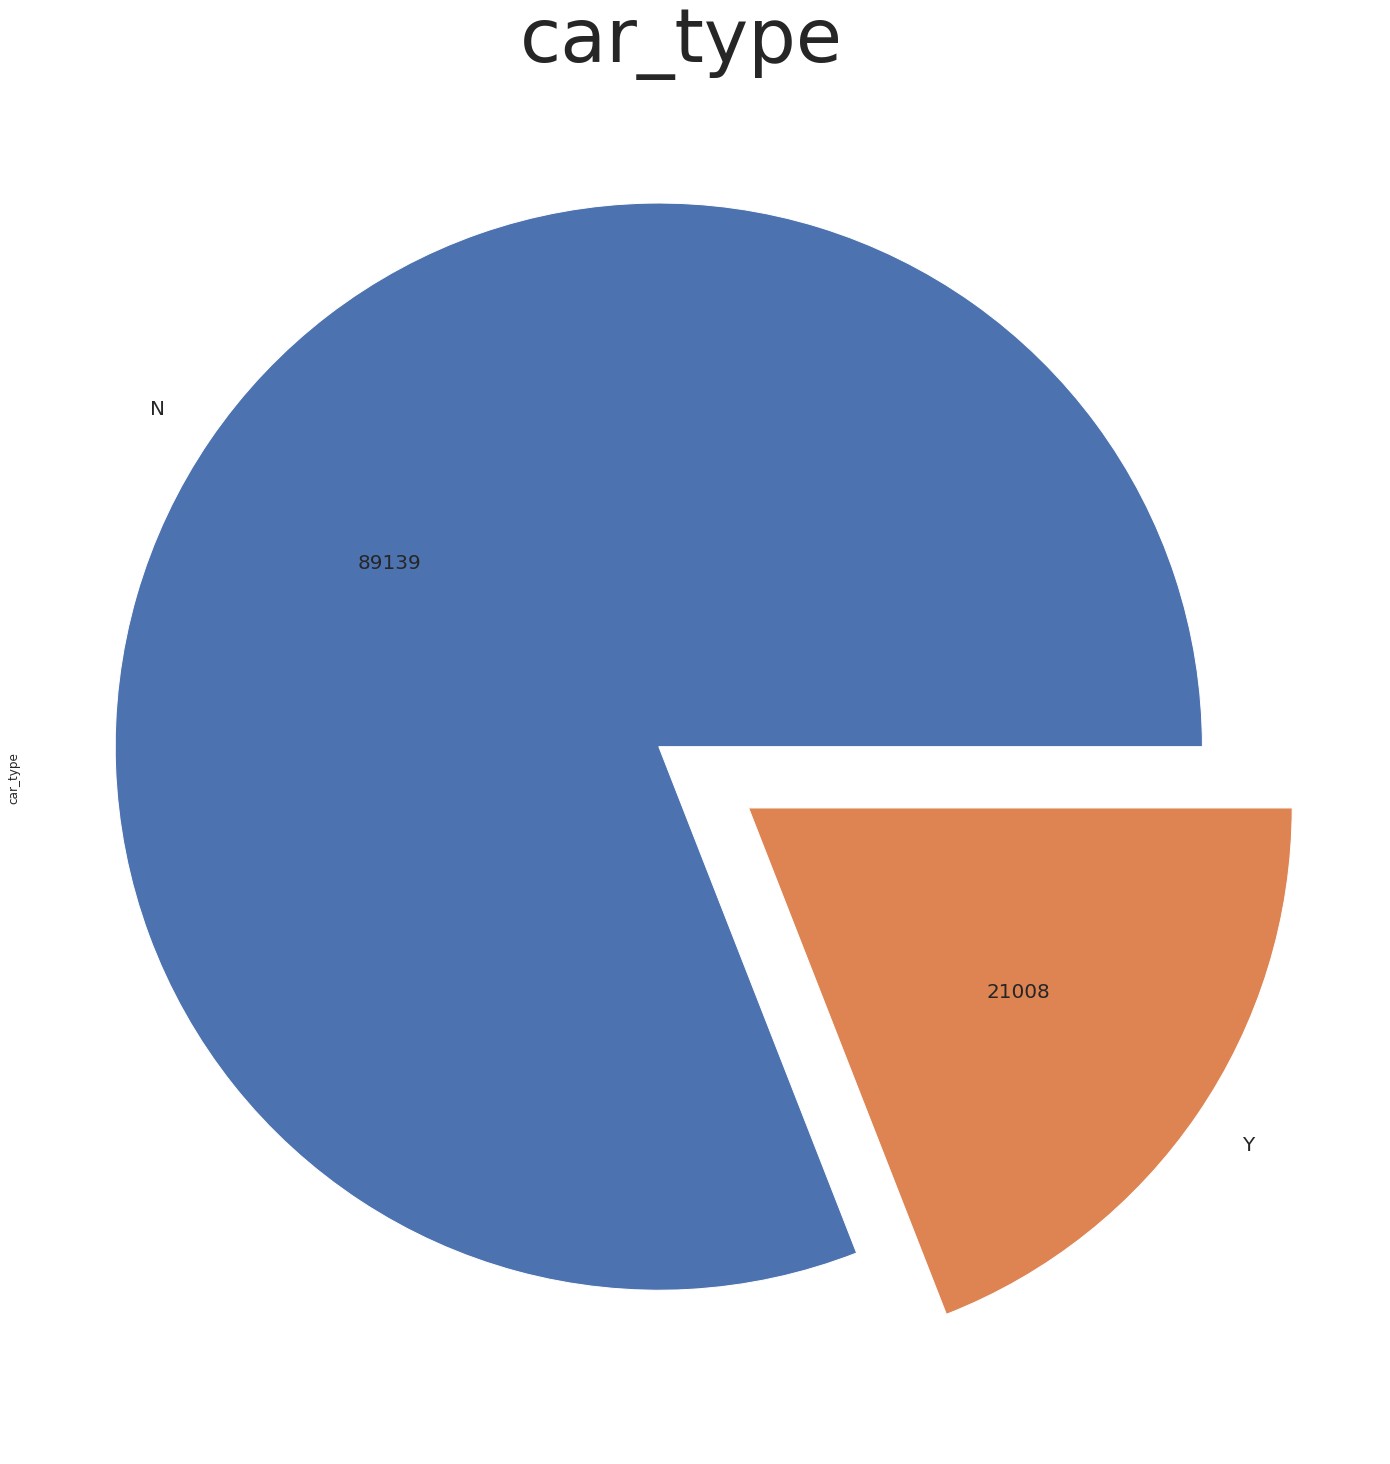

In [30]:
pie_chart(df['car_type'])
value_counts_p(df['car_type'])

* Кредит берут больше людей, у которых отсутствует иномарка

#### Посмотрим как наличия иномарки влияет на дефолд

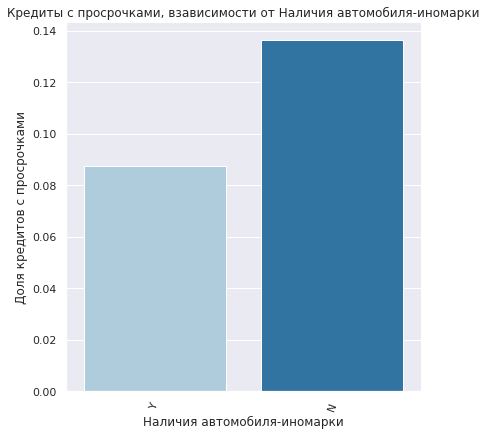

In [31]:
factorplot('car_type', 'default', 'Наличия автомобиля-иномарки', 'Наличия автомобиля-иномарки')

**Вывод**:
* У заемщиков у которох есть автомобиль-иномарка берут меньше кредит
* Спорный признак

In [32]:
# Преобразуем параметр в бинарный числовой формат
df['car_type'] = label_encoder.fit_transform(df['car_type'])
df_tmp['car_type'] = df['car_type']

## decline_app_cnt - количество отказанных прошлых заявок

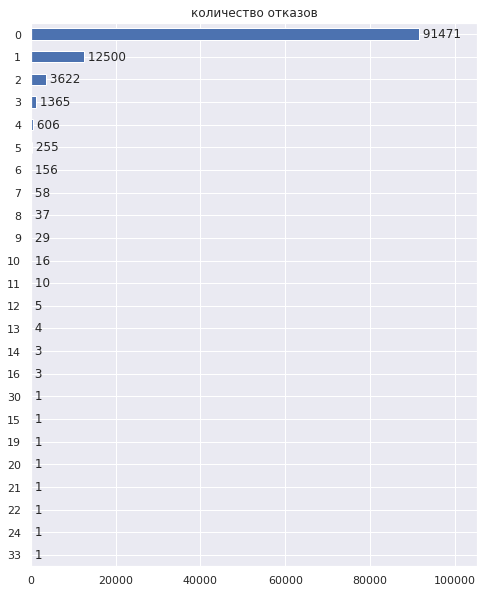

In [33]:
bar(df, 'decline_app_cnt', 'количество отказов')

#### Посмотрим как количество отказанных в прошлом заявок влияет на выплату кредита

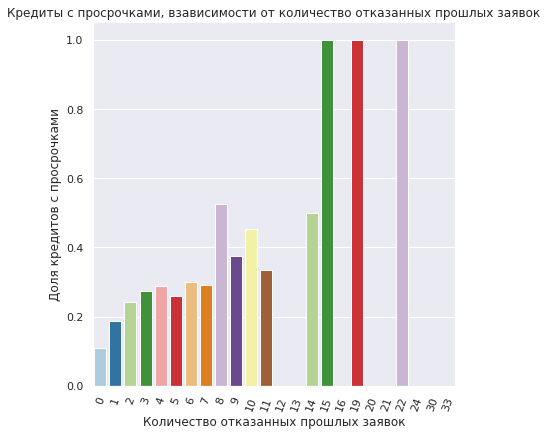

In [34]:
factorplot('decline_app_cnt', 'default', 'количество отказанных прошлых заявок', 'Количество отказанных прошлых заявок')

**Вывод:**
* Необходимо логарифмировать и нормировать признак
* Много единичных случаев с большим кол-ом заявок
* Большинству клиентов не отказывали в кредите.

In [35]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
df_tmp['decline_app_cnt'] = df['decline_app_cnt']

## Good_work - наличие хорошей работы

,good_work
0,83.4
1,16.6


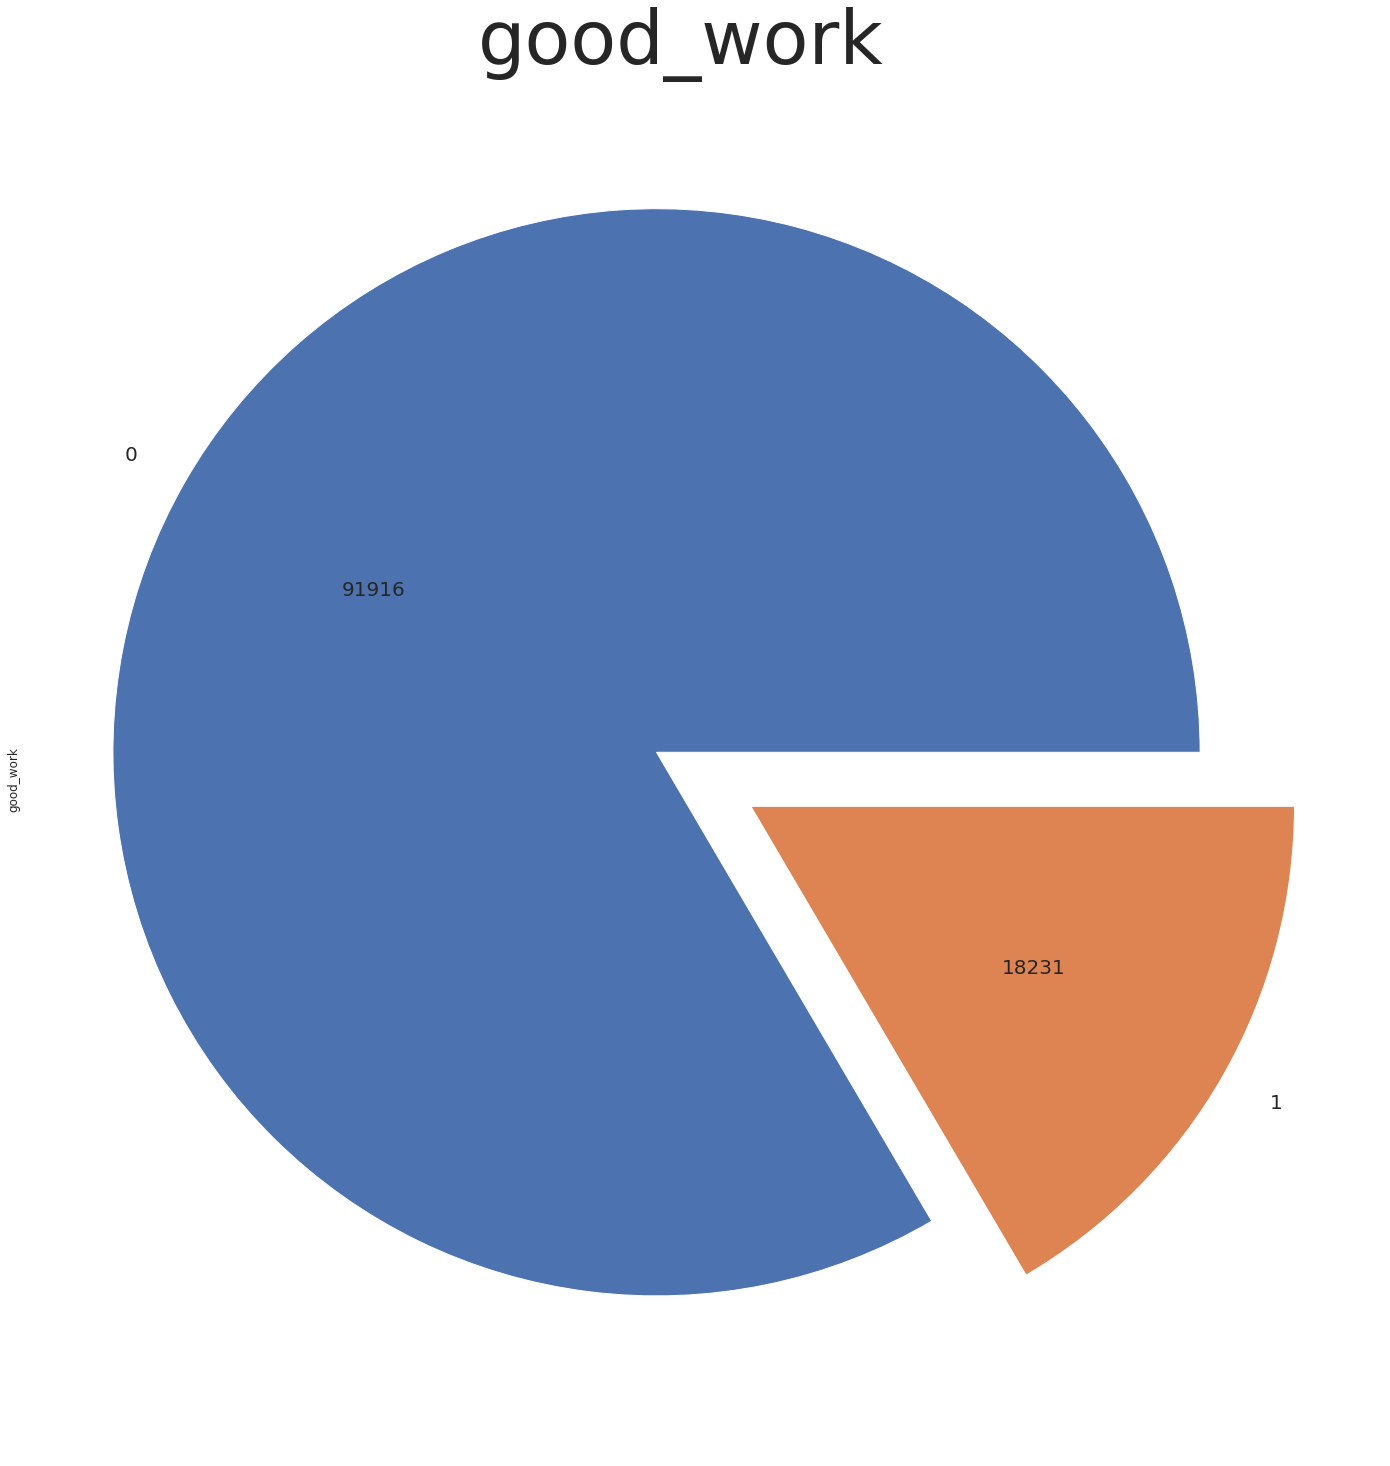

In [36]:
pie_chart(df['good_work'])
value_counts_p(df['good_work'])

* Только у 16% имеется хорошая работа

#### Посмотрим как наличие хорошей работы влияет на дефолт

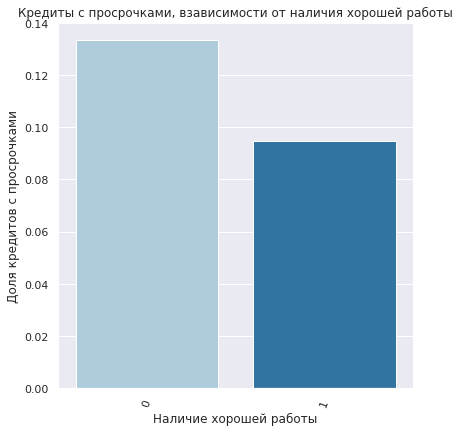

In [37]:
factorplot('good_work', 'default', 'наличия хорошей работы', 'Наличие хорошей работы')

**Вывод**:
* 84% кто берет кридит не имеет хорошую работу
* Большинство заемщиков, не имеют хорошей работы

## bki_request_cnt - количество запросов в БКИ
*Бюро кредитных историй (БКИ). БКИ обрабатывают и хранят информацию о всех, кто когда-либо брал или запрашивал кредиты.*

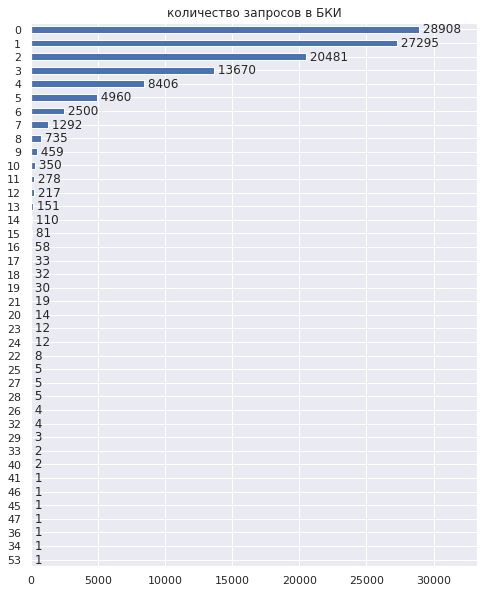

In [38]:
bar(df, 'bki_request_cnt', 'количество запросов в БКИ')

* Распределение логнормальное

#### Посмотрим на выбросы

<AxesSubplot:xlabel='bki_request_cnt'>

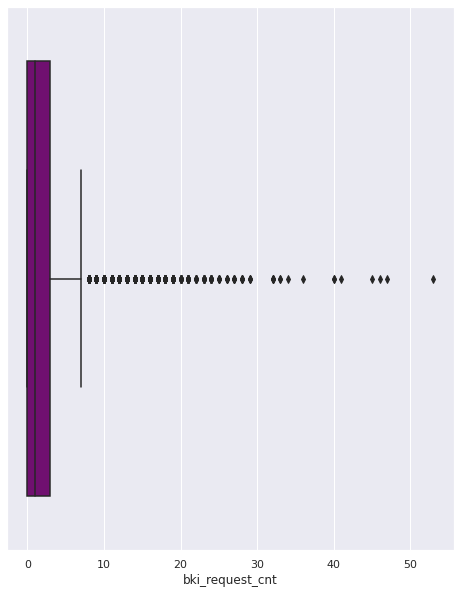

In [39]:
sns.boxplot(df.bki_request_cnt, color='purple')

#### Посмотрим как количество количество запросов в БКИ влияет на дефолт

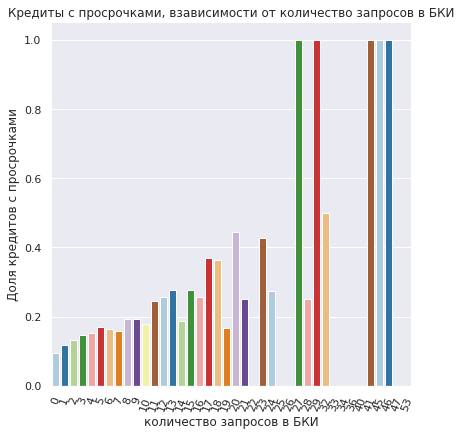

In [40]:
factorplot('bki_request_cnt', 'default', 'количество запросов в БКИ', 'количество запросов в БКИ')

* Данны сильно смешенны их нужно логарифмировать

In [41]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
df_tmp['bki_request_cnt'] = df['bki_request_cnt']

**Вывод**:
* много выбросов,пока затрудняюсь сделать выводы,что с ними делать
* После логарифмирование данные не такие смещенные 
* Количество запросов в БКИ в среднем больше у клиентов, допустивших дефолт по кредиту.

## home_address -  домашний адрес

,home_address
2,54.1
1,44.2
3,1.7


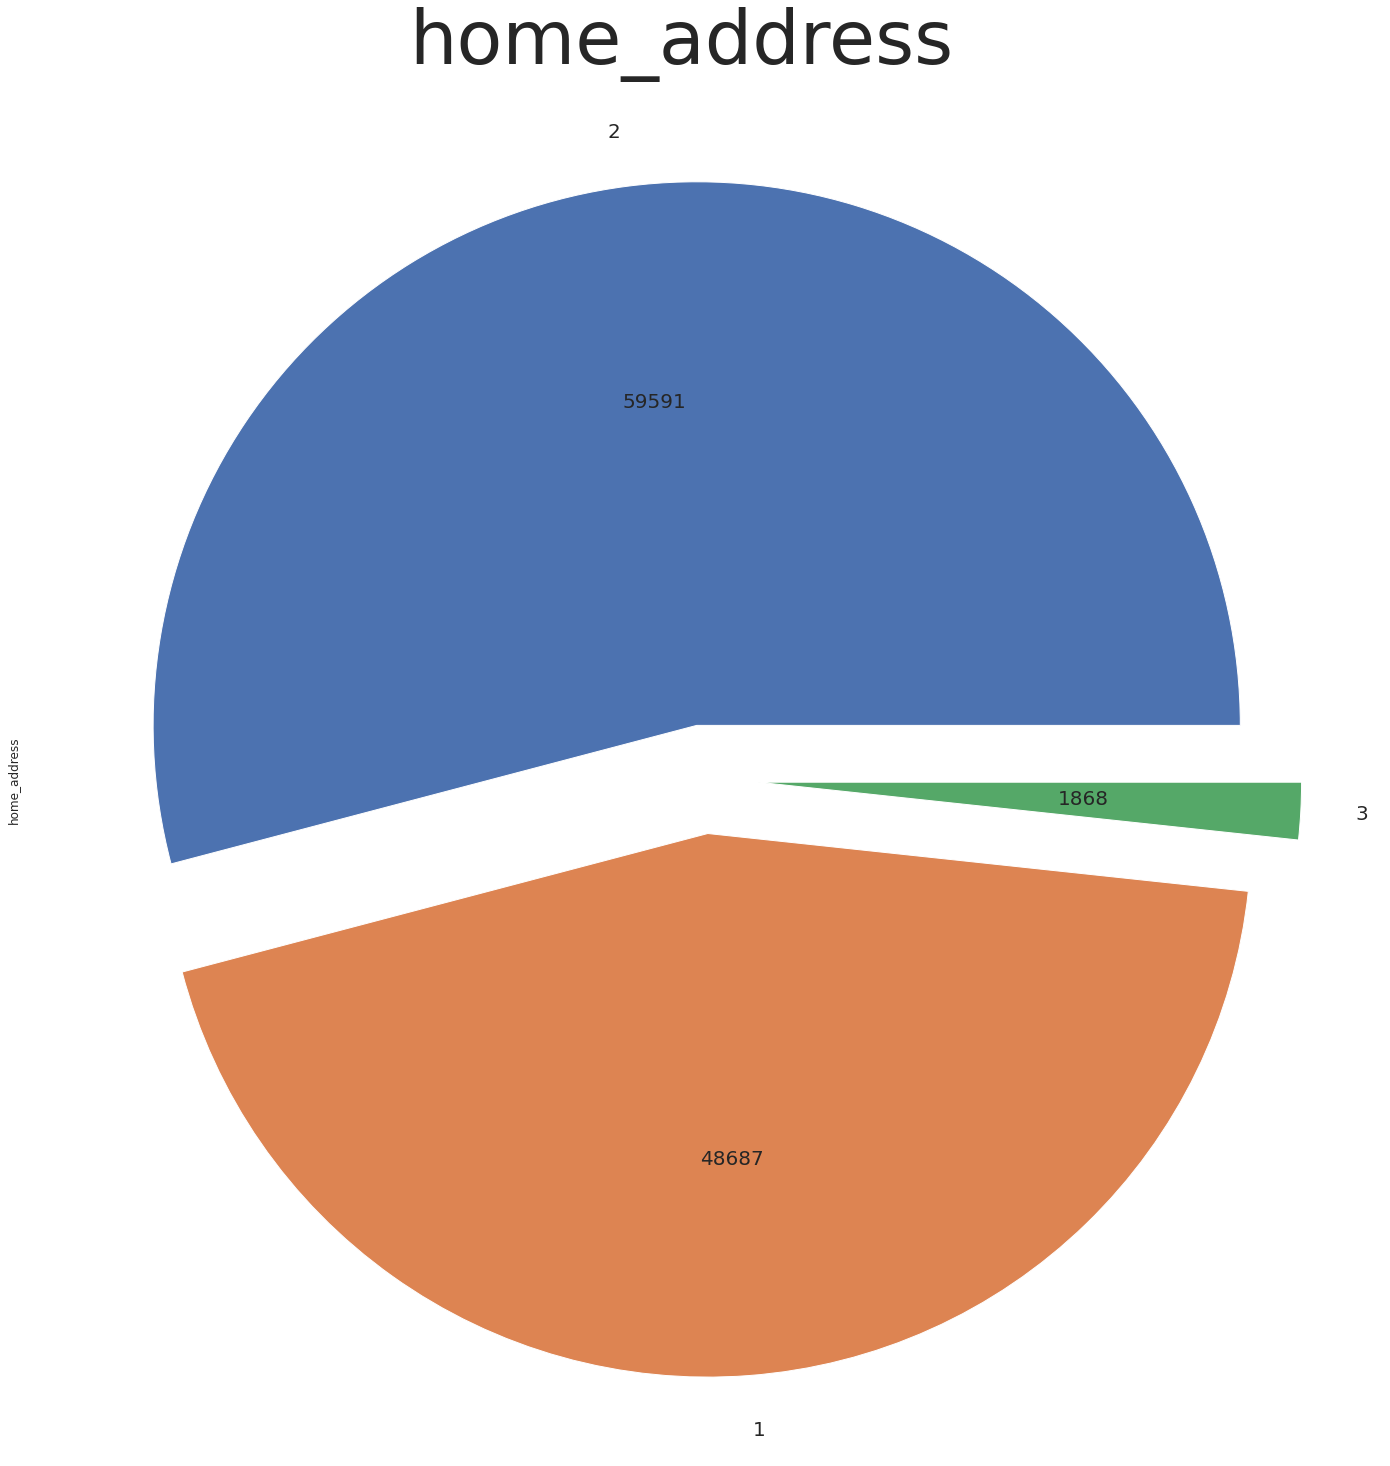

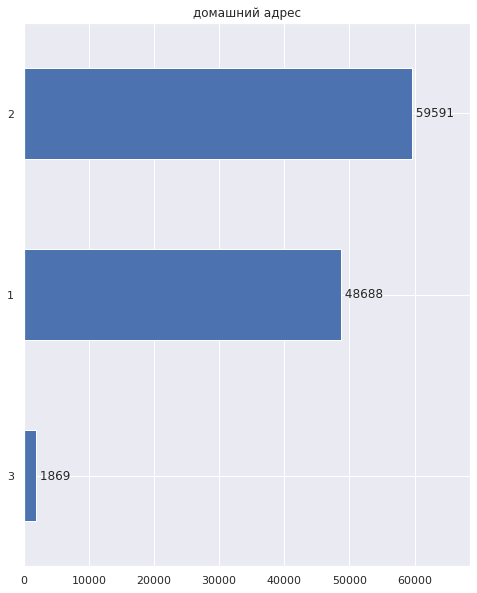

In [42]:
pie_chart(df['home_address'])
value_counts_p(df['home_address'])
bar(df, 'home_address', 'домашний адрес')

* Большинства заемщиков живут в двух районах, и только 2% в третьем

#### Посмотрим как домашний адрес влияет на дефолт

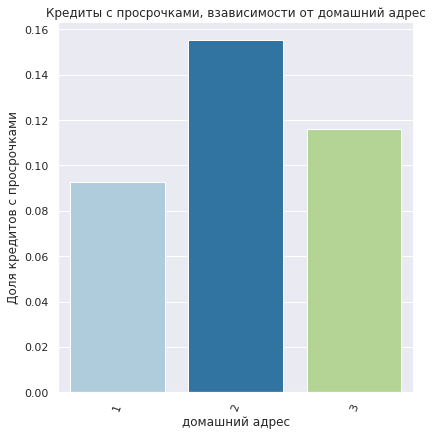

In [43]:
factorplot('home_address', 'default', 'домашний адрес', 'домашний адрес')

**Вывод**:
* Пока сложно сказать и сделать выводы об этом признаке


In [44]:
# Dummy-переменные в df_tmp
df_tmp['home_address'] = df['home_address']
df_tmp = pd.get_dummies(df_tmp, columns=['home_address'])

## work_address - категоризатор рабочего адреса

,work_address
3,60.9
2,27.9
1,11.1


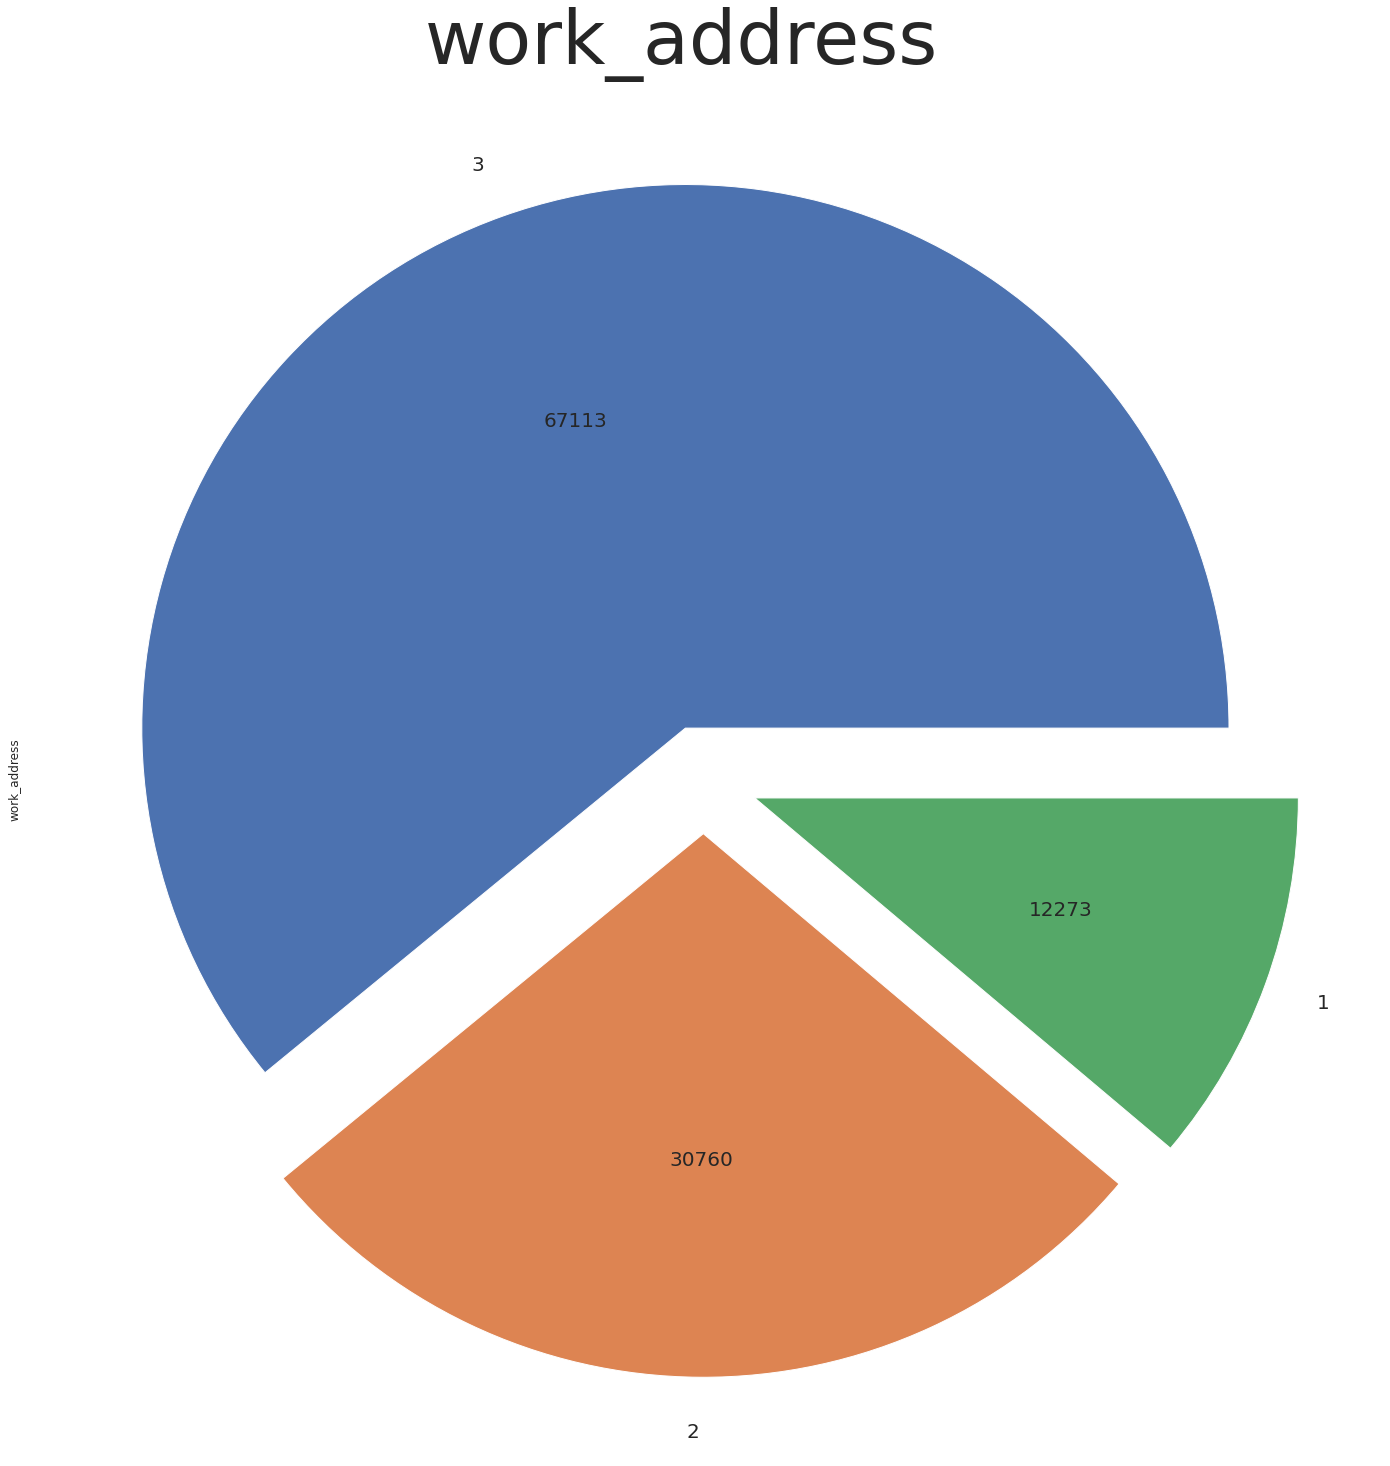

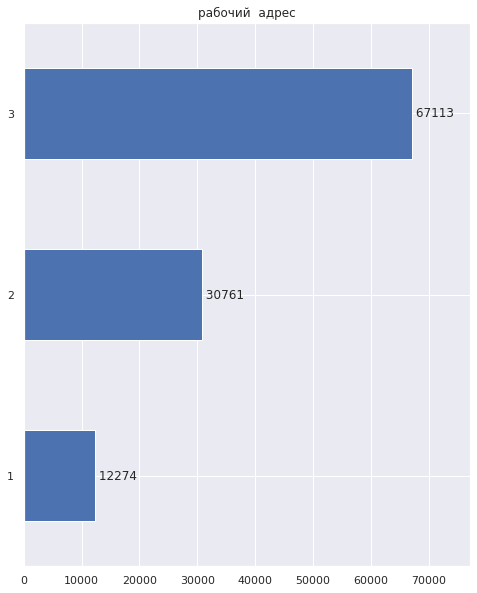

In [45]:
pie_chart(df['work_address'])
value_counts_p(df['work_address'])
bar(df, 'work_address', 'рабочий  адрес')

* 61% работают в третьем районе, 27% во втором и 11% в первом 

#### Посмотрим как влияет место работы на дефолт

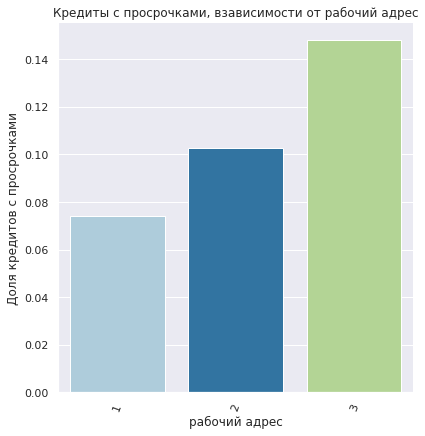

In [46]:
factorplot('work_address', 'default', 'рабочий адрес', 'рабочий адрес')

**Выводы**:
* так же тяжело судить об этом признаки

In [47]:
# Dummy-переменные в df_tmp
df_tmp['work_address'] = df['work_address']
df_tmp = pd.get_dummies(df_tmp, columns=['work_address'])

#### Предположение
Возможно, данные в *home_adress* и *work_address* относятся к району. Таким образом, если разделить одно на другое, то можно получить идентификатор удаленности работы от дома. При этом единица будет в случае совпадения районов и чем больше число будет отличаться от 1, тем большая будет разница между районами проживания и работы (тесты показали положительную эффективность данного параметра).

In [48]:
df['rel_address'] = df['work_address'] / df['home_address']

## income - доход заёмщика
*Построем логарифмическую гистограмму, так как много уникальных значений и большой разброс*

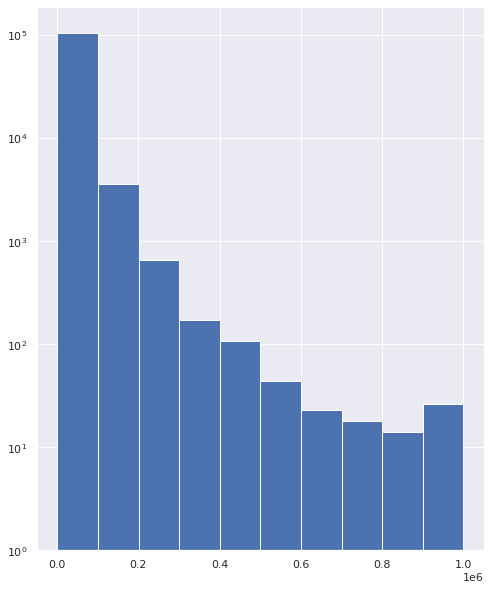

In [49]:
ax = df.income.hist(bottom=1)
ax.set_yscale('log')

* Распределение логнормальное

#### Посмотрим как доход заемщика влият на дефолд

In [50]:
# factorplot('income', 'default', 'доход заёмщика', 'Доход заёмщика')

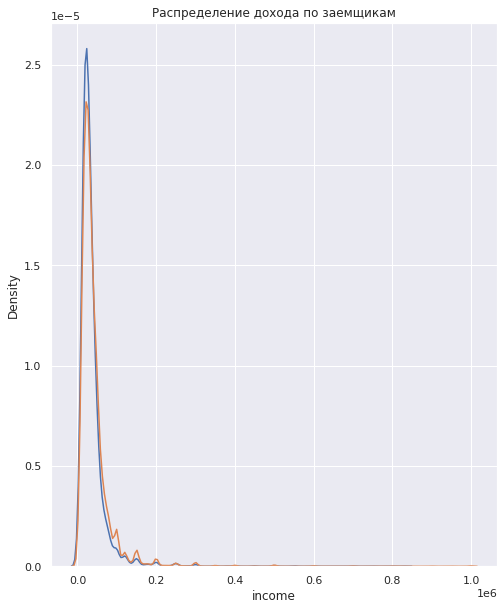

In [51]:

sns.kdeplot(df_train.loc[df_train['default'] == 1, 'income'], label = 'default')

sns.kdeplot(df_train.loc[df_train['default'] == 0, 'income'], label = 'nondefault')

plt.title('Распределение дохода по заемщикам');

In [52]:
# логарифмируем income
df['income'] = np.log(df['income'] + 1)
df_tmp['income'] = df['income']

**Вывод**:
* у заемщиков которы допускают дефолт зарплата меньше

## foreign_passport - наличие загранпаспорта

,foreign_passport
N,85.1
Y,14.9


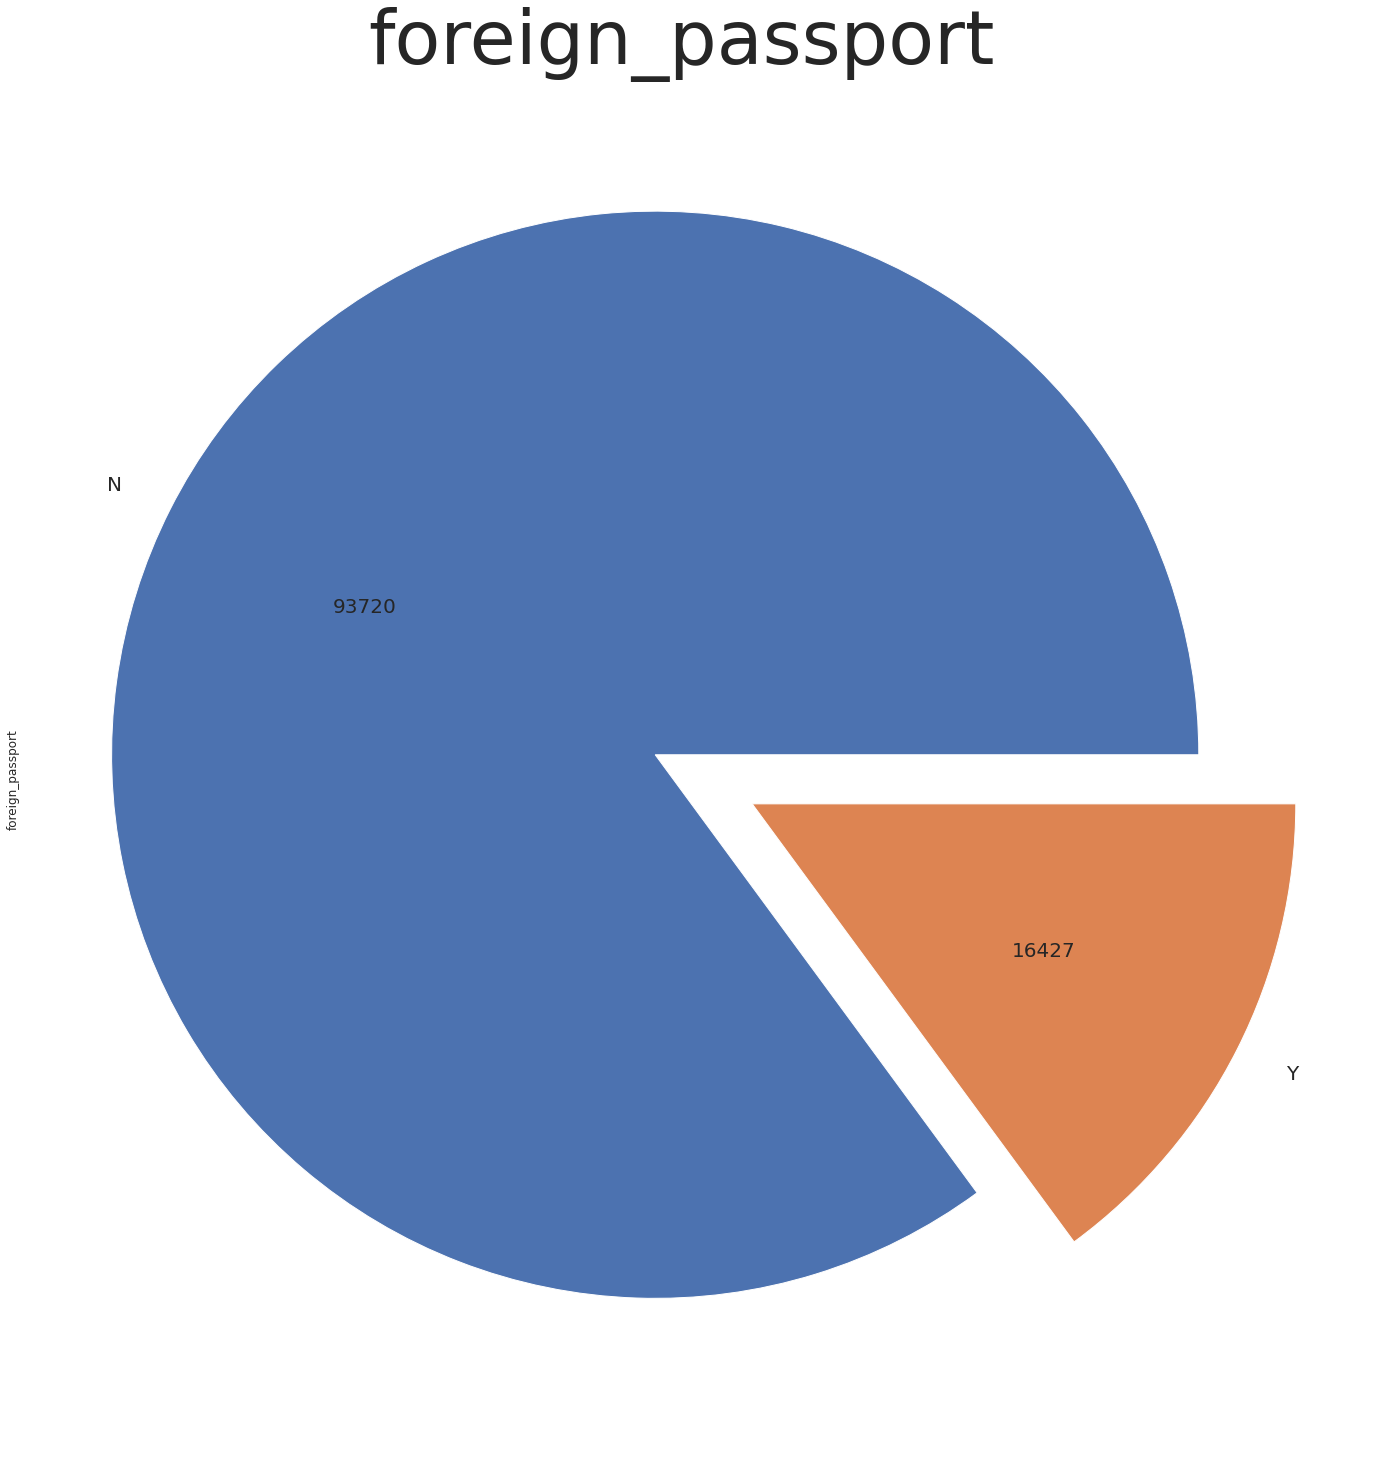

In [53]:
pie_chart(df['foreign_passport'])
value_counts_p(df['foreign_passport'])

* На графиках видно, что большая часть а это 85% которы оброщаются за кредитом не имеют загранпаспорта

#### Посмортим как наличие загранпапотра влияет на не возврат кредита

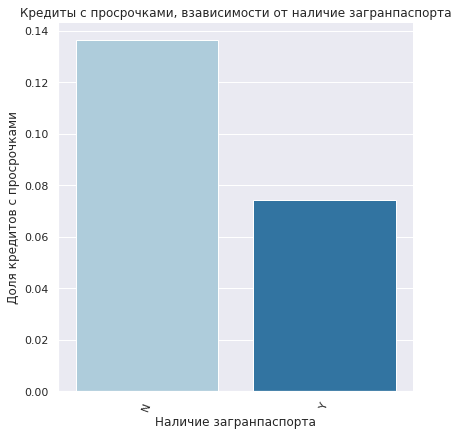

In [54]:
factorplot('foreign_passport', 'default', 'наличие загранпаспорта', 'Наличие загранпаспорта')

**Вывод:**
* Только у 15% заемщиков есть наличия загранпаспорта 

In [55]:
# Преобразуем параметр в бинарный числовой формат
df['foreign_passport'] = label_encoder.fit_transform(df['foreign_passport'])
df_tmp['foreign_passport'] = df['foreign_passport']

## client_id - идентификатор клиента

* Это не признак, а числовой индификатор
* Удалим этот признак, для модели он не несет никакого смысла, а только создаст шум

In [56]:
df.drop(['client_id'], axis=1, inplace=True)

## score_bki - скоринговый балл по данным из БКИ
*Скоринговый балл – это показатель платежеспособности заемщика, выраженный в цифровом формате. Чем больше балл, тем выше вероятность одобрения заявки. Даже с нулевой кредитной историей заемщик будет иметь свой рейтинг. Он будет зависеть от пола, возраста, места работы, должности, наличия собственности и т. д.*

25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].


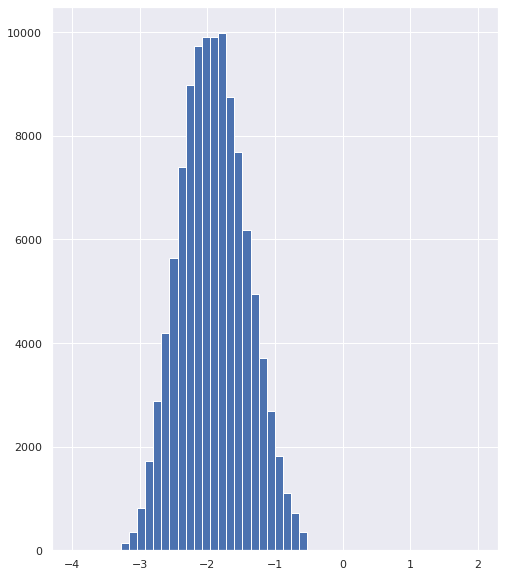

In [57]:
iqr_test('score_bki', -4, 2, 50)

In [58]:
df['score_bki'] = abs(df['score_bki'])
df['score_bki'] = np.log(df['score_bki'] + 1)
df_tmp['score_bki'] = df['score_bki']

## region_rating - рейтинг региона

,region_rating
50,37.2
60,21.8
40,16.3
80,15.6
70,8.4
30,0.4
20,0.3


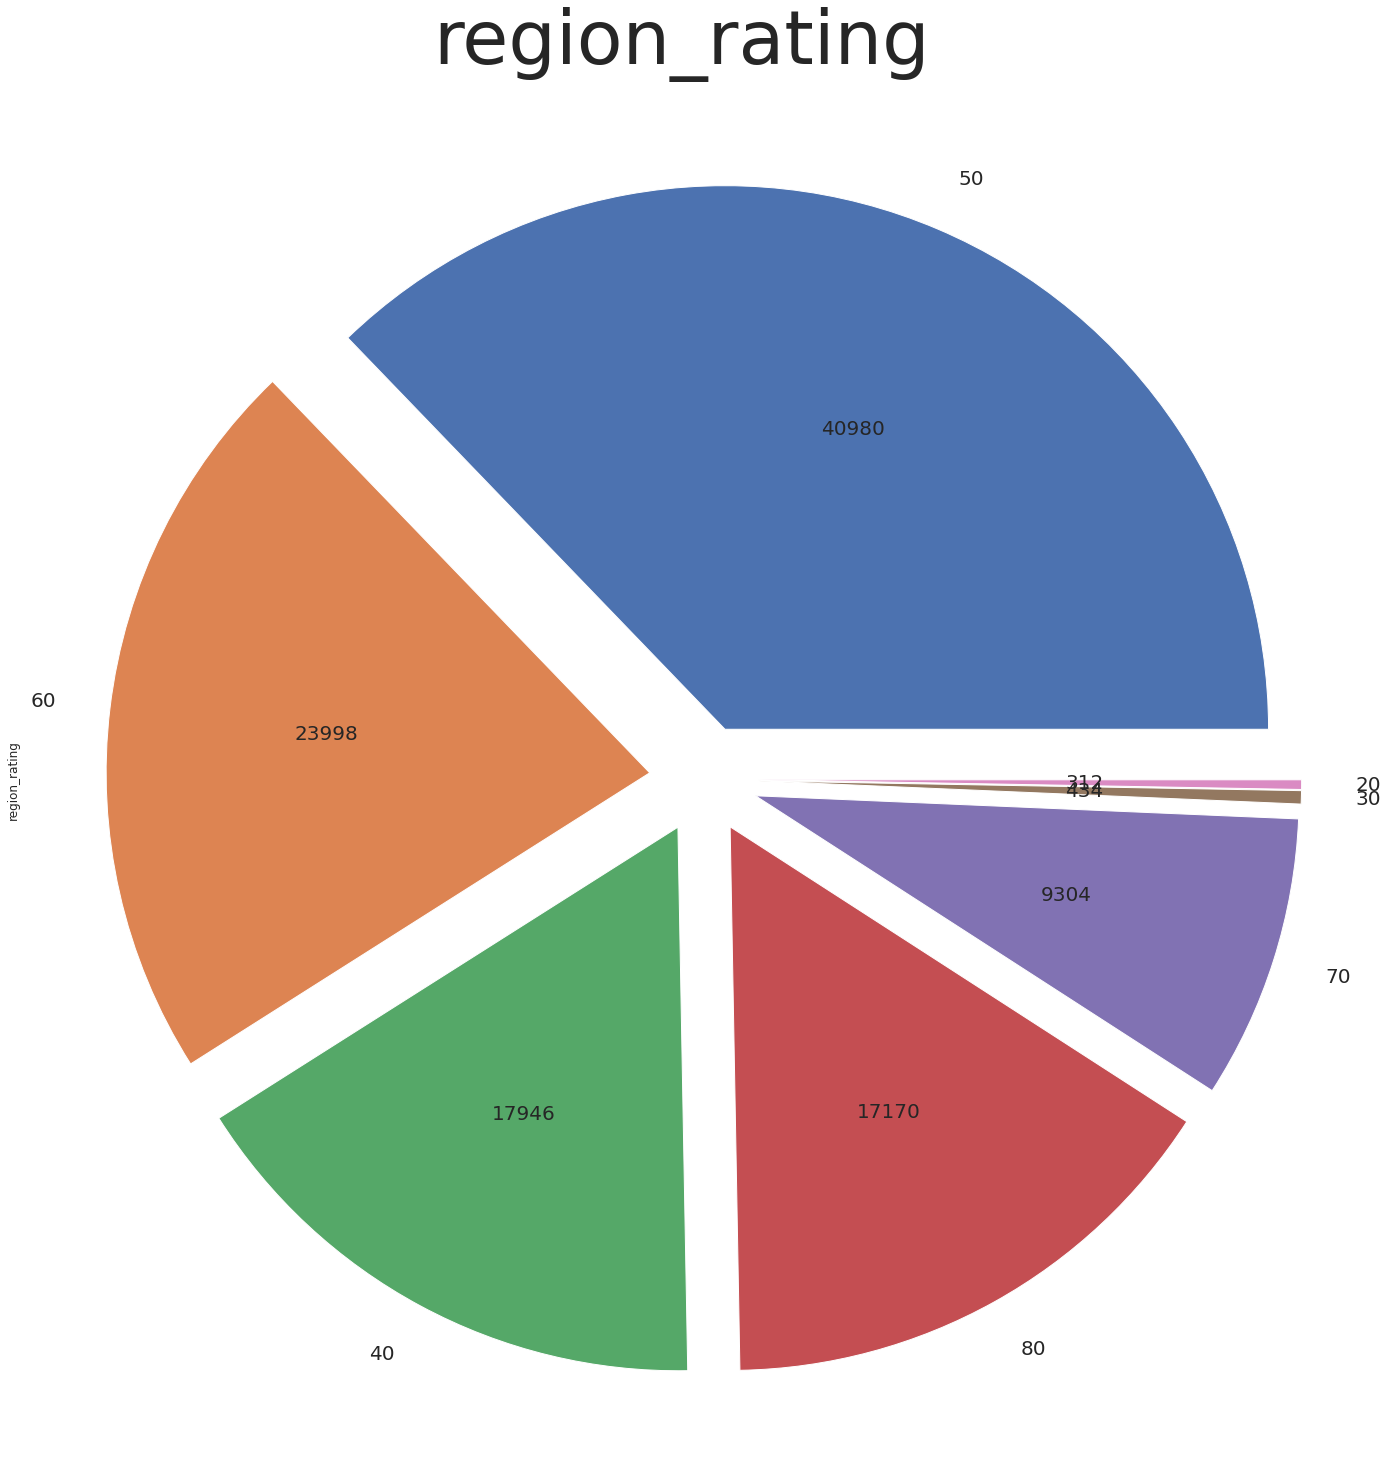

In [59]:
pie_chart(df['region_rating'])
value_counts_p(df['region_rating'])

* 7 вариантов значений. Большинство клиентов относятся к 50-му региону.

#### Посмотрим как рейтинг региона влияет на дефолт

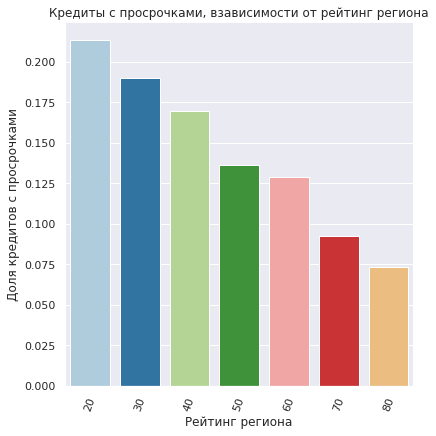

In [60]:
factorplot('region_rating', 'default', 'рейтинг региона', 'Рейтинг региона')

**Вывод:**
* Сложно судить

In [61]:
# Dummy-переменные в df_tmp
df_tmp['region_rating'] = df['region_rating']
df_tmp = pd.get_dummies(df_tmp, columns=['region_rating'])

## sna - связь заемщика с клиентами банка

,sna
1,64.2
4,15.9
2,14.4
3,5.6


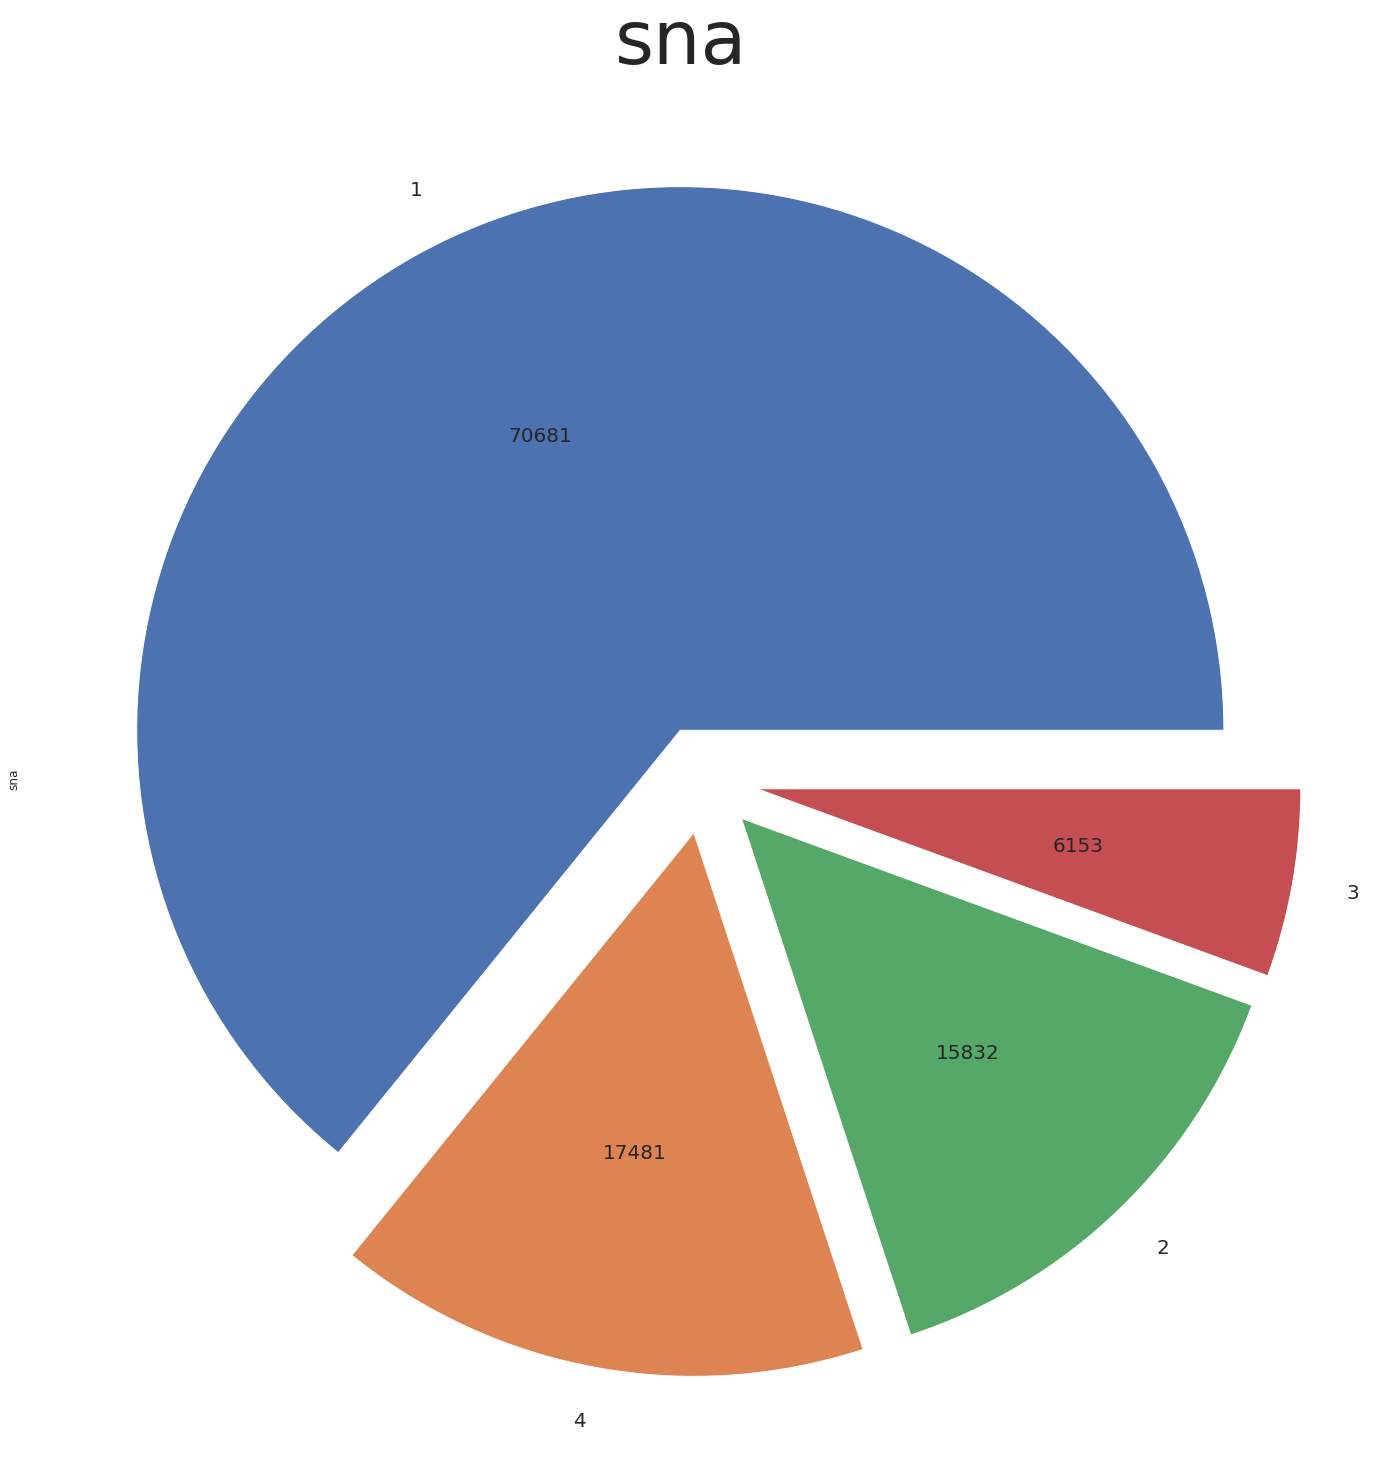

In [62]:
pie_chart(df['sna'])
value_counts_p(df['sna'])

* 4 варианта значения

#### Посмотрим как связь заемщика с клиентами банки влияет на дефолт

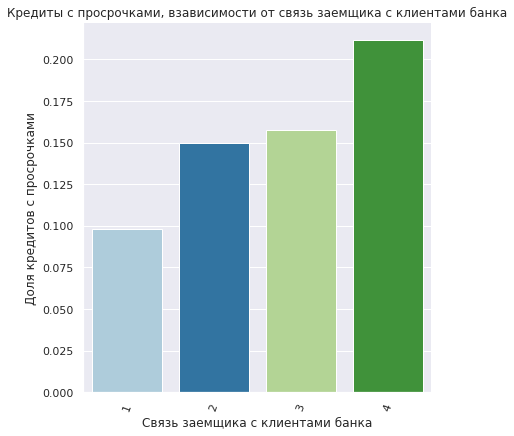

In [63]:
factorplot('sna', 'default', 'связь заемщика с клиентами банка', 'Связь заемщика с клиентами банка')

**Вывод:**
* 

In [64]:
# Dummy-переменные в df_tmp
df_tmp['sna'] = df['sna']
df_tmp = pd.get_dummies(df_tmp, columns=['sna'])

## app_date - дата подачи заявки

In [65]:
# Преобразуем в формат 

df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')



In [66]:
# # Год
# df['app_date'].dt.year.value_counts()
# # Месяц
# df['app_date'].dt.month.value_counts()
# # День недели
# df['app_date'].dt.dayofweek.value_counts()
# df['Rev_weekday'] = df['app_date'].dt.dayofweek

* В признаке данные только за 2014 год.
* И только за 4 месяца.
* Так же данные за все 7 дней недель
* Разделения не дало результат !!! 

#### Сколько дней прошло с даты подачи заявки до сегодняшнего дня

In [67]:
# df['date_delta_today'] = (date_today - df['app_date']).dt.days

* Тоже не дало результат

#### Найдет первую и последнию дату

In [68]:
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [69]:
df['days'] = (df.app_date - start).dt.days.astype('int')
df_tmp['days'] = df['days']

## first_time - давность наличия информации о заемщике

,first_time
3,42.3
4,25.4
1,16.6
2,15.7


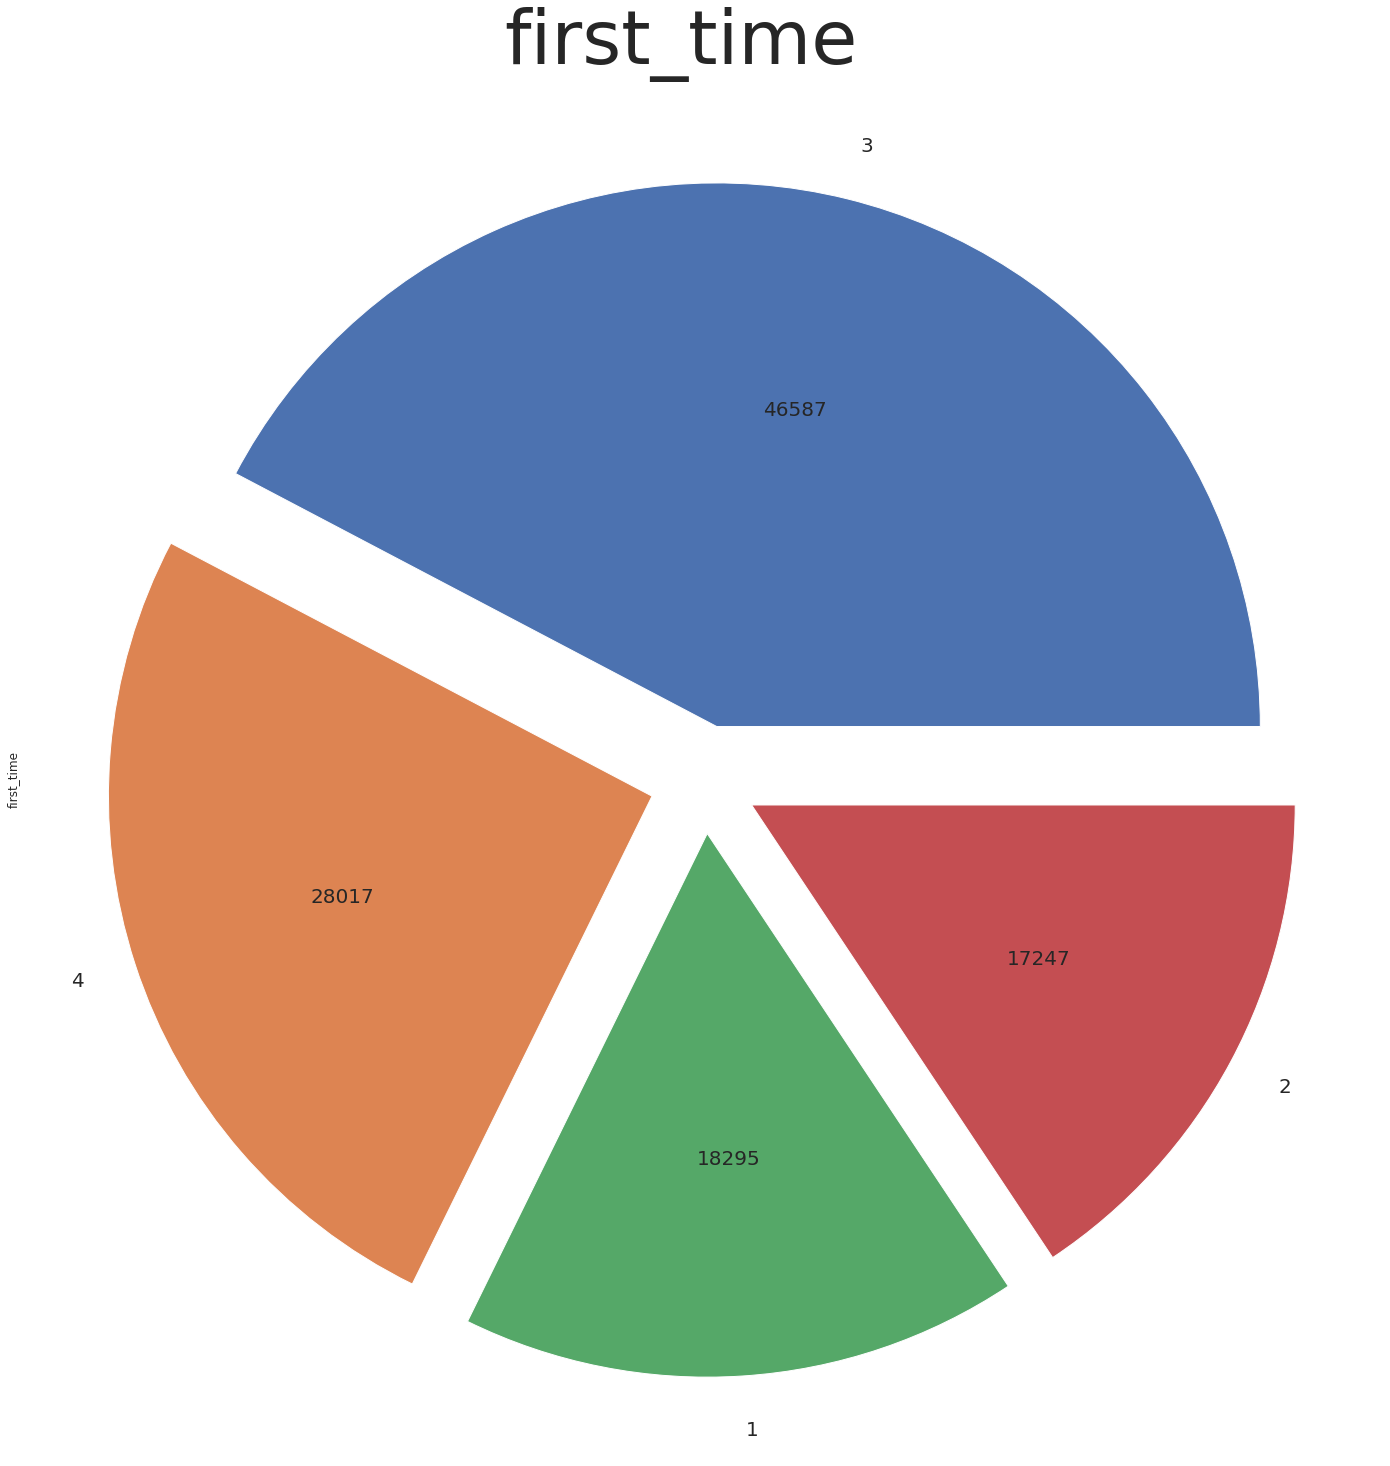

In [70]:
pie_chart(df['first_time'])
value_counts_p(df['first_time'])

#### Посмотрим как давность наличия информации о заемщике влияет на дефолт

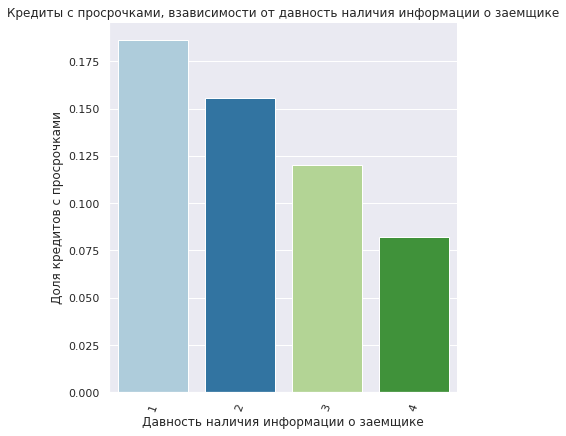

In [71]:
factorplot('first_time', 'default', 'давность наличия информации о заемщике', 'Давность наличия информации о заемщике')

**Вывод:**
* 4 категории значений.

In [72]:
# Dummy-переменные в df_tmp
df_tmp['first_time'] = df['first_time']
df_tmp = pd.get_dummies(df_tmp, columns=['first_time'])

# Feature Engeenering

<AxesSubplot:xlabel='same_address'>

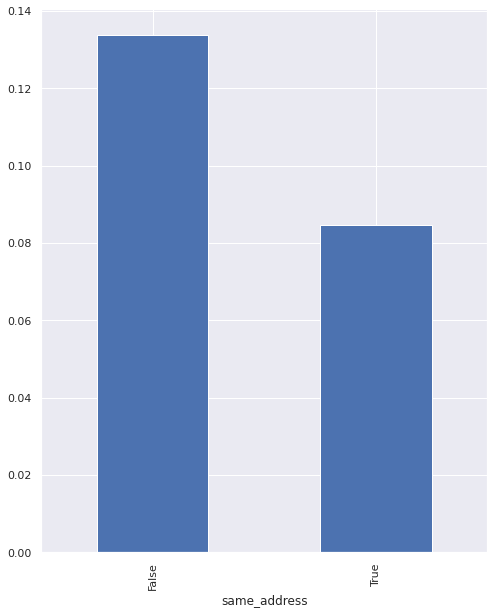

In [73]:
# если район тот же самы
df['same_address'] = df['work_address'] == df['home_address']

df.groupby(['same_address'])['default'].mean().plot.bar()

In [74]:
# Dummy-переменные в df_tmp
df_tmp['same_address'] = df['same_address']
df_tmp = pd.get_dummies(df_tmp, columns=['same_address'])

<AxesSubplot:xlabel='comb_address'>

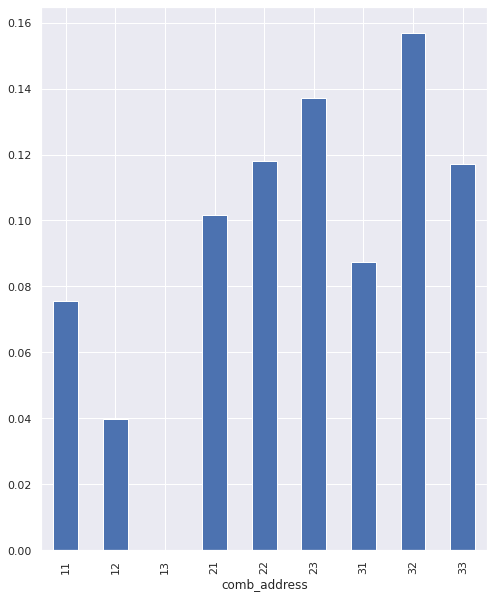

In [75]:
#  комбинация районов и работы
df['comb_address'] = df['work_address'].astype(str) + df['home_address'].astype(str)

df.groupby(['comb_address'])['default'].mean().plot.bar()

In [76]:
# # Dummy-переменные в df_tmp
# df_tmp['comb_address'] = df['comb_address']
# df_tmp = pd.get_dummies(df_tmp, columns=['comb_address'])

* 'comb_address' только ухудшил модель

* Наличие автомобиля и иномарки - car* 

*изменим тип признака car на категориальный: 0 - нет авто, 1 - есть автомобиль (не иномарка) 2 - иномарка*

In [77]:
df.loc[df.car=='N', 'car'] = 0
df.loc[df.car=='Y', 'car'] = 1
df.loc[df.car_type=='Y', 'car'] = 2
df.drop(columns=['car_type'], inplace=True)

# Распределим параметры по классам

In [78]:
# Бинарные переменные
bin_cols = ['sex', 'car','good_work', 'foreign_passport']

# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', "comb_address",
            'sna', 'first_time', 'region_rating']

# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'days', 'rel_address']

## Логарифмируем оставшиеся числовые признаки
*Чтобы сделать данные менее смещенным. Также добавим признаки в df_tmp*

In [79]:
for col in ['age', 'decline_app_cnt', 'rel_address']:
    df[col] = np.log(df[col] + 1)
    df_tmp[col] = df[col]

In [80]:
df_tmp

,sample,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,sex,car,car_type,decline_app_cnt,...,sna_4,days,first_time_1,first_time_2,first_time_3,first_time_4,same_address_False,same_address_True,age,rel_address
0,0,0,1,0,0,0,1,1,1,0.000000,...,0,80,0,0,0,1,1,0,1.481877,1.098612
1,0,0,0,0,1,0,0,0,0,1.026672,...,1,23,0,0,1,0,1,0,1.545194,1.098612
2,0,0,0,0,0,1,1,1,1,0.000000,...,0,81,0,0,1,0,1,0,1.595709,1.098612
3,0,0,0,0,1,0,1,0,0,0.000000,...,0,33,0,0,1,0,1,0,1.618011,1.098612
4,0,0,1,0,0,0,0,0,0,0.000000,...,0,34,0,0,1,0,1,0,1.539779,0.916291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,1,0,1,0,0,0,0,0,0,0.000000,...,1,62,0,0,0,1,1,0,1.574565,1.098612
110144,1,0,0,0,1,0,1,1,1,0.000000,...,0,82,0,0,0,1,0,1,1.555545,0.693147
110145,1,0,0,0,1,0,1,0,0,0.000000,...,0,111,0,1,0,0,1,0,1.496434,0.916291
110146,1,0,0,0,1,0,0,0,0,0.000000,...,0,3,0,0,1,0,1,0,1.481877,1.386294


## Посмотрим корреляции

In [81]:
df[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income,score_bki,days,rel_address
age,1.000000,-0.129185,0.051335,-0.084851,0.105424,0.017961,-0.021304
decline_app_cnt,-0.129185,1.000000,0.126793,-0.014600,-0.210751,-0.021806,0.008247
bki_request_cnt,0.051335,0.126793,1.000000,0.078649,-0.140663,-0.008747,-0.005704
income,-0.084851,-0.014600,0.078649,1.000000,-0.007246,0.002498,0.021940
score_bki,0.105424,-0.210751,-0.140663,-0.007246,1.000000,0.062673,0.002430
days,0.017961,-0.021806,-0.008747,0.002498,0.062673,1.000000,-0.039118
rel_address,-0.021304,0.008247,-0.005704,0.021940,0.002430,-0.039118,1.000000


<AxesSubplot:>

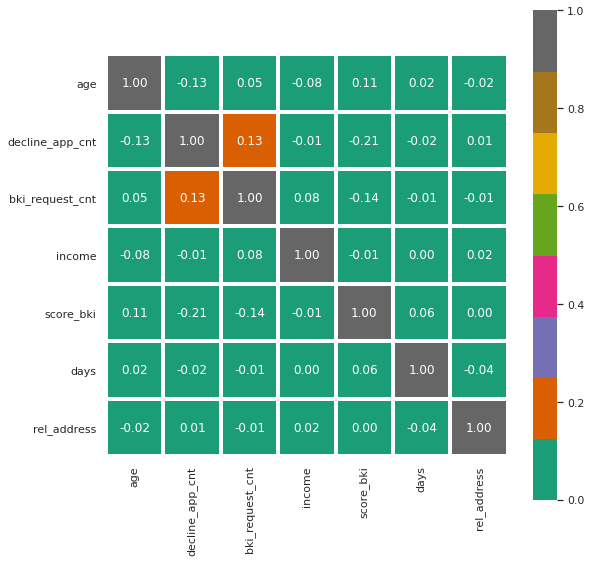

In [82]:
df[num_cols].corr()
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(df[num_cols].corr(), vmin=0, vmax=1, annot=True,
            fmt=".2f", linewidths=3, cmap='Dark2', square=True)

Что мы можем сказать:
* Все признаки слабо скореллированы между собой, это очень хорошо для нашей линейной модели! можно все взять в модель.
* 21% корреляция между Скоринговым баллом по данным из БКИ и Количеством отказанных прошлых заявок.
* 14% корреляция между Количеством запросов в БКИ и Скоринговым баллом по данным из БКИ.
* 13% корреляция между Количеством запросов в БКИ и Количеством отказанных прошлых заявок.
* 13% обратная корреляция между Количеством отказанных прошлых заявок и Возрастом заемщиков.

## Значимость непрерывных переменных
#### Однофакторный дисперсионный анализ (ANOVA).
В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [83]:
defa = df.default.fillna(3)

<AxesSubplot:>

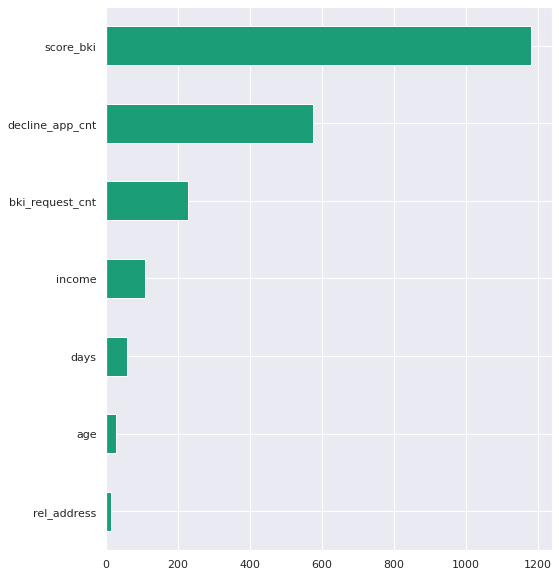

In [84]:
imp_num = pd.Series(f_classif(df[num_cols], defa)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', cmap='Dark2')

* Самым значимым из числовых параметром является Скоринговый балл по данным из БКИ, что подтверждает сделанный вывод при детальном анализе данного параметра.

##  Категориальные переменные

<AxesSubplot:>

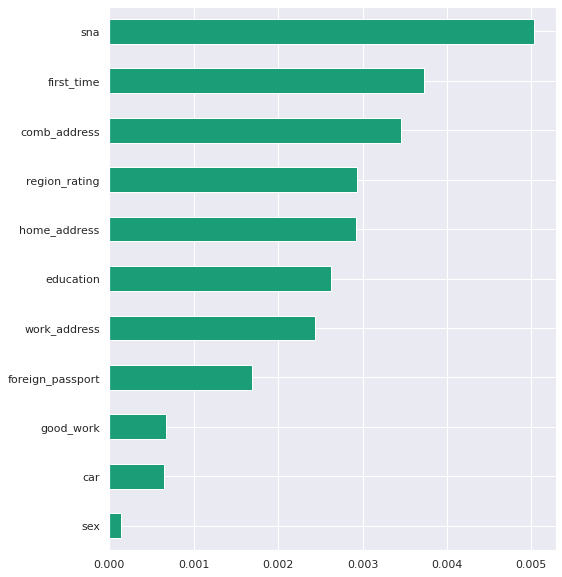

In [85]:
imp_cat = pd.Series(mutual_info_classif(
    df[bin_cols + cat_cols],defa, discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', cmap='Dark2')

**Вывод:**
* На основе данных о значимости признаков, после предварительного тестирования, можно создать дополнительные параметры для улучшения качества классификатора.

# Подготовка данных к машинному обучению

In [86]:
for col in num_cols:
    df_tmp[col] = StandardScaler().fit_transform(df_tmp[[col]].values)

In [87]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sample              110148 non-null  int64  
 1   education_ACD       110148 non-null  uint8  
 2   education_GRD       110148 non-null  uint8  
 3   education_PGR       110148 non-null  uint8  
 4   education_SCH       110148 non-null  uint8  
 5   education_UGR       110148 non-null  uint8  
 6   sex                 110148 non-null  int64  
 7   car                 110148 non-null  int64  
 8   car_type            110148 non-null  int64  
 9   decline_app_cnt     110148 non-null  float64
 10  bki_request_cnt     110148 non-null  float64
 11  home_address_1      110148 non-null  uint8  
 12  home_address_2      110148 non-null  uint8  
 13  home_address_3      110148 non-null  uint8  
 14  work_address_1      110148 non-null  uint8  
 15  work_address_2      110148 non-nul

# Промежуточное тестирование

<Figure size 576x720 with 0 Axes>

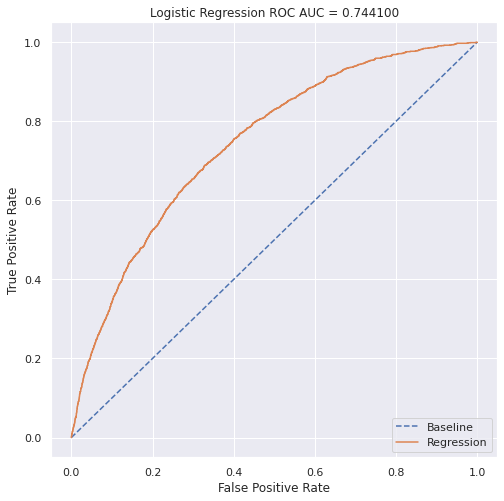

In [88]:
df_for_test = df_tmp.query('sample == 1').drop(['sample'], axis=1)
X = df_for_test.values
test_metrics(X, y)

# Корреляции всех признаков и дополнительные параметры

<AxesSubplot:>

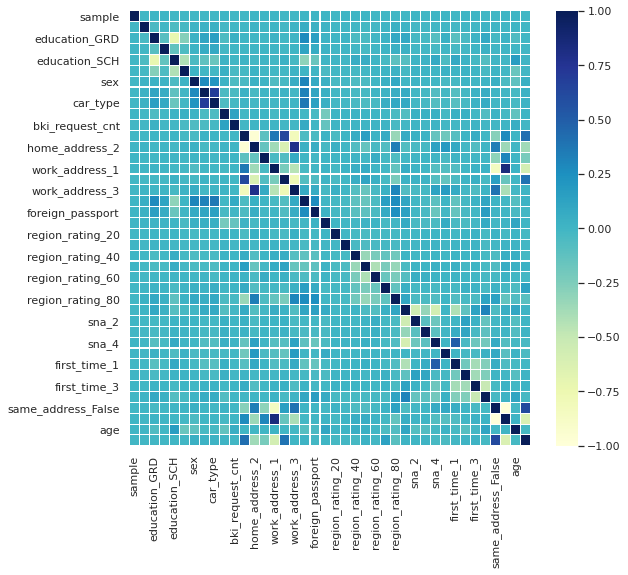

In [89]:
corrmat = df_tmp.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 


**Вывод:**
* Есть довольно сильно скоррелированные признаки в итоговом дата сете, однако 100% корреляции нет нигде.
* Поочередное удаление сильно скоррелированных признаков в каждом случае ухудшает качество модели, поэтому оставил все параметры.
* Все созданные дополнительные параметры, положительно влияющие на модель, в итоговом варианте ноутбука внесены в пункты по анализу параметров (выше).
* Все дополнительные параметры, которые ухудшали качество модели, в итоговый дата сет не включены

# Регуляризация

In [90]:
%%time
# Добавим типы регуляризации
penalty = ['l1','l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=RANDOM_SEED, max_iter=500)
model.fit(X, y)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, y)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245
CPU times: user 2min 31s, sys: 54.6 s, total: 3min 26s
Wall time: 51.8 s


<Figure size 576x720 with 0 Axes>

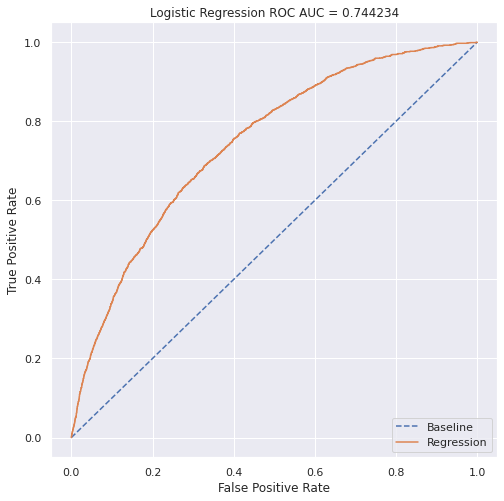

In [91]:
test_metrics(X, y, 2.7825594022071245)

# SUBMISSION

In [92]:
data_train = df_tmp.query('sample == 1').drop(['sample'], axis=1)
data_test = df_tmp.query('sample == 0').drop(['sample'], axis=1)

y_predicted = best_model.predict_proba(data_test)

submit = pd.DataFrame(df_test['client_id'])
submit['default'] = y_predicted[:,1]

submit.to_csv('submit-v12.csv', index=False)

## Выводы
- Удалось создать классификатор логистической регрессии и повысить качество его предсказательной способности. Показатель ROC AUC вырос с 0,558 до 0,745.
- Проведена работа по анализу и обогащению входных данных. Выводы по признакам приведены после обработки каждого параметра.
- Логарифмирование и нормализация числовых параметров существенно повышает предсказательную способность модели.
- Проведена большая работа по созданию и тестированию новых параметров. Большая часть данной работы не вошла в итоговый ноутбук из-за низкой эффективности большого количества новых параметров. Вывод по данному пункту – то, что хорошо работало для деревьев, не сработало для логистической регрессии из-за специфики алгоритма